# Data Import

In [40]:
import pandas as pd
import csv
import glob
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

## read in files

In [41]:
# create list of all files in data
path = r'C:\Users\neomo\Documents\GitHub\ky-nf-capstone\data'
all_files = glob.glob(path + "/*.tsv")

In [42]:
# split list in data and position files
pos_files = []
pos_files.append(all_files.pop(1))
pos_files.append(all_files.pop(2))

In [43]:
# read in position file 1 for later reference 
with open(pos_files[0], 'r') as csvfile:
    data = csv.reader(csvfile, delimiter='\t', quotechar='|')
    positions_1 = []
    for i in data:
            if len(i[1].split(";")) > 2 :
                a = i[1].split(";")
                a.append(i[0])
                positions_1.append(a[::-1])

In [44]:
# read in position file 2 for later reference 
with open(pos_files[1], 'r') as csvfile:
    data = csv.reader(csvfile, delimiter='\t', quotechar='|')
    positions_2 = []
    for i in data:
            if len(i[1].split(";")) > 2 :
                a = i[1].split(";")
                a.append(i[0])
                positions_2.append(a[::-1])

In [45]:
# read in main files one by one, append file name, ref and modified state

df_proto = []

for file in all_files:
    file_name = os.path.basename(file)
    # split filenames into sets to compare to modified filename for later reference
    exp_set = set(os.path.basename(file).replace(".","_").split("_"))
    mod_set1 = set(os.path.basename(pos_files[0]).replace(".","_").split("_"))
    mod_set2 = set(os.path.basename(pos_files[1]).replace(".","_").split("_"))
    # have to do it complicated like this because they are underneath each other with their ref number es inbetween header
    with open(file, 'r') as csvfile:
        data = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for i in data:
            # get ref number, refnumber has only 2 entries side by side
            if len(i) == 2:
                read = i[0]
                ref = i[1]
            # for further stuff only get those where first one is integer (those are the data rows)
            try:
                int(i[0])
            except:
                pass
            else:
                # append ref and file name for later aggregation
                a = i
                a.append(ref)
                a.append(file_name)
                a.append(read)
                # if file in loop is one of the modified files (test by subset of mod pos file) append modified status
                if exp_set.issubset(mod_set1):
                    for idx, elm in enumerate(positions_1):
                        if elm[0] == a[4]:
                            a.append((a[0] in positions_1[idx])*1)  
                if exp_set.issubset(mod_set2):
                    for idx, elm in enumerate(positions_2):
                        if elm[0] == a[4]:
                            a.append((a[0] in positions_2[idx])*1)  
                df_proto.append(a)
               
        
            
     

In [46]:
# form list of lists into dataframes, fill nas with 0, as they are from unmodified dataset
df = pd.DataFrame(df_proto)
df.fillna(0,inplace=True)

In [47]:
# give columns proper names
columns = ["ref_pos","ref_kmer","dwell_time","median_value","ref_number","file_name","read_num","modified_status"]
df.columns = columns

In [48]:
# type conversion
df.ref_pos = df.ref_pos.astype(int)
df.ref_kmer = df.ref_kmer.astype(str)
df.dwell_time = df.dwell_time.astype(float)
df.median_value = df.median_value.astype(float)
df.ref_number = df.ref_number.astype(str)
df.file_name = df.file_name.astype(str)
df.modified_status = df.modified_status.astype("category")

## Aggregation of reads from same sequence

In [49]:
# aggregate by file name, ref number, ref pos and kmer and calculate median, stdt min and max
df_combined = df.groupby(["file_name","ref_number","ref_pos","ref_kmer"]).agg(["median","min","max"]).reset_index()
df_combined.columns = [' '.join(col).strip() for col in df_combined.columns.values]
df_combined["modified_status"] = df.groupby(["file_name","ref_number","ref_pos","ref_kmer"]).first().reset_index().modified_status
df_combined.columns =  [elm.replace(" ","_") for elm in df_combined.columns]

In [50]:
# get column sequence to reorder uncombined dataframe
columns = list(df_combined.columns)
for i in range(6):
    columns.pop(4)
columns.insert(4,"read_num")
columns.insert(5,"dwell_time")
columns.insert(6,"median_value")
df_not_combined = df
df_not_combined = df_not_combined[columns]

# feature engineering

## split base sequence

In [51]:
# split dna sequence for combined to later use it in a one hot encoded manner to see if the base sequence is important
kmer_combined = [list(elm) for elm in df_combined.ref_kmer]
df_kmer_combined = pd.DataFrame(kmer_combined)
df_kmer_combined.columns = ["base_1","base_2","base_3","base_4","base_5"]
df_combined = pd.concat([df_combined,df_kmer_combined], axis=1)


In [52]:
# split sequences for not combined
kmer = [list(elm) for elm in df.ref_kmer]
df_kmer = pd.DataFrame(kmer)
df_kmer.columns = ["base_1","base_2","base_3","base_4","base_5"]
df_not_combined = pd.concat([df,df_kmer], axis=1)


## file type

In [53]:
#create feature for type of file (as i have 2 files for each state), just for visualization purposes

m_fnames = ["modified_rep_1.tsv","modified_rep_2.tsv"]
file_type = df_combined["file_name"].isin(m_fnames)*1
file_type = ["modified" if i == 1 else "unmodified" for i in file_type]

df_combined["file_type"] = file_type

In [54]:
m_fnames = ["modified_rep_1.tsv","modified_rep_2.tsv"]
file_type = df_not_combined["file_name"].isin(m_fnames)*1
file_type = ["modified" if i == 1 else "unmodified" for i in file_type]

df_not_combined["file_type"] = file_type

In [55]:
df_combined

file_name ref_number  ref_pos ref_kmer  dwell_time_median  \
0       modified_rep_1.tsv   ref_0000        0    AATGG           0.049906   
1       modified_rep_1.tsv   ref_0000        1    ATGGG           0.023089   
2       modified_rep_1.tsv   ref_0000        2    TGGGC           0.022861   
3       modified_rep_1.tsv   ref_0000        3    GGGCT           0.006346   
4       modified_rep_1.tsv   ref_0000        4    GGCTT           0.014807   
...                    ...        ...      ...      ...                ...   
3915  unmodified_rep_2.tsv   ref_0004      191    CGTGC           0.006429   
3916  unmodified_rep_2.tsv   ref_0004      192    GTGCC           0.011771   
3917  unmodified_rep_2.tsv   ref_0004      193    TGCCT           0.008358   
3918  unmodified_rep_2.tsv   ref_0004      194    GCCTG           0.008379   
3919  unmodified_rep_2.tsv   ref_0004      195    CCTGA           0.015557   

      dwell_time_min  dwell_time_max  median_value_median  median_value_min  \
0           0.005113        0.094814           102.017702         87.318945   
1           0.008614        0.063580           100.448388         80.185500   
2           0.002792        0.089663           118.765173        102.514759   
3           0.001938        0.049635           115.110460         97.295992   
4           0.002748        0.075328           112.652922        102.709198   
...              ...             ...                  ...               ...   
3915        0.002019        0.042936            90.079018         68.866058   
3916        0.002281        0.124091            84.075921         78.351843   
3917        0.002183        0.044366           103.709799         93.545775   
3918        0.002509        0.036329            70.458988         62.061483   
3919        0.002346        0.064867            93.706971         88.339205   

      median_value_max modified_status base_1 base_2 base_3 base_4 base_5  \
0           108.891074             1.0      A      A      T      G      G   
1           119.615164             0.0      A      T      G      G      G   
2           126.849837             0.0      T      G      G      G      C   
3           131.978892             0.0      G      G      G      C      T   
4           120.275825             0.0      G      G      C      T      T   
...                ...             ...    ...    ...    ...    ...    ...   
3915        114.458366             0.0      C      G      T      G      C   
3916         92.026334             0.0      G      T      G      C      C   
3917        111.413839             0.0      T      G      C      C      T   
3918         77.727195             0.0      G      C      C      T      G   
3919        106.329963             0.0      C      C      T      G      A   

       file_type  
0       modified  
1       modified  
2       modified  
3       modified  
4       modified  
...          ...  
3915  unmodified  
3916  unmodified  
3917  unmodified  
3918  unmodified  
3919  unmodified  

[3920 rows x 17 columns]

## rolling mean for pos +/- 2

Here i want to use the sequential nature of the data. I check each read of each file seperately. In the nanopore technique one string of dna (one read) is analysed as a whole in sequence. So read position 1 will always come after read position zero. The read frame is 5 bases. so i calculate the rolling mean and rolling minimum of dwell time and median for each position +2 and -2 bases. The idea is, that the read is classified as modified if it is in the middle of the read. But the modified base is technically also in the reads +2 -2 of this specific position and influences the values. So if i take the rolling minimum of +2 and -2 positions, only the read with the modification in the middle will have a high value.

### dwell time

In [56]:
def rolling_neighbours(dataframe, values, method, min_periods = 3): 
    # create file name list to iterate through
    file_name_list = list(dataframe.file_name.unique())
    # create ref num list to iterate through
    ref_num_list = list(dataframe.ref_number.unique())
    # prepare empty data frame to concatenate each step of the for loops
    temp_df = pd.DataFrame()
    #nested for loop through ref nums and file names
    for ref_num in ref_num_list:
        for file_name in file_name_list:
            # create a mask for future reference
           
            msk = dataframe[(dataframe["ref_number"] == ref_num) & 
                   (dataframe["file_name"] == file_name)]
           
            # create a read num list for each of these instances, as every ref_num (dna sequence) is read multiple times
            # in each file and also analysed in each file, hence the iteration through files
            if "read_num" in dataframe.columns:
                read_num_list = list(msk.read_num.unique())
            
            # another nested for loop to go through each read_num of each file and each contained ref_num (dna sequence)
            # for each read_num i calculate rolling median (and min in future loops) for dwell time and median value
            # and add corresponding read num, file name, ref_num and ref_pos for merging purposes
                for idx,read_num in enumerate(read_num_list):
                    if method == "median":
                        temp_df2 = pd.DataFrame(msk[msk["read_num"] == read_num][values]\
                                                .rolling(5,center=True, min_periods = min_periods).median())
                    if method == "min":
                        temp_df2 = pd.DataFrame(msk[msk["read_num"] == read_num][values]\
                                                .rolling(5,center=True, min_periods = min_periods).min())
                    if method == "max":
                        temp_df2 = pd.DataFrame(msk[msk["read_num"] == read_num][values]\
                                                .rolling(5,center=True, min_periods = min_periods).max())
                    temp_df2["read_num"] = read_num
                    temp_df2["file_name"] = file_name
                    temp_df2["ref_num"] = ref_num
                    temp_df2.reset_index(inplace=True)
                    temp_df2["ref_pos"] = msk[msk["read_num"] == read_num].ref_pos.values
                    temp_df = pd.concat([temp_df, temp_df2], axis=0)
                    
            else:
                if method == "median":
                    temp_df2 = pd.DataFrame(msk[values + "_median"]\
                            .rolling(5,center=True, min_periods = min_periods).median())
                if method == "min":
                    temp_df2 = pd.DataFrame(msk[values + "_median"]\
                            .rolling(5,center=True, min_periods = min_periods).min())
                if method == "max":
                    temp_df2 = pd.DataFrame(msk[values]\
                            .rolling(5,center=True, min_periods = min_periods).max())
                temp_df2["file_name"] = file_name
                temp_df2["ref_num"] = ref_num
                temp_df2.reset_index(inplace=True)
                temp_df2["ref_pos"] = np.arange(len(msk))
                temp_df = pd.concat([temp_df, temp_df2], axis=0)
    temp_df.pop("index")
    # rename columns for merging purposes
    if "read_num" in dataframe.columns:
        temp_df.columns = [values + "_rolling_" + method,"read_num","file_name","ref_number","ref_pos"]
    else:
        temp_df.columns = [values + "_rolling_" + method,"file_name","ref_number","ref_pos"]
    return temp_df

##### Not_combined

In [57]:
temp_df = rolling_neighbours(df_not_combined, "dwell_time", "median")

In [58]:
# merge with original data frame
df_not_combined = df_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

##### combined 

In [59]:
temp_df = rolling_neighbours(df_combined, "dwell_time", "median")

In [60]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

### median

##### not combined

In [61]:
temp_df = rolling_neighbours(df_not_combined, "median_value", "median")

In [62]:
df_not_combined = df_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

###### combined

In [63]:
temp_df = rolling_neighbours(df_combined, "median_value", "median")

In [64]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

## rolling min for pos +/- 2

### dwell time

##### not combined

In [65]:
temp_df = rolling_neighbours(df_not_combined, "dwell_time", "min")

In [66]:
df_not_combined = df_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

##### combined

In [67]:
temp_df = rolling_neighbours(df_combined, "dwell_time", "min")

In [68]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

### median

##### not combined

In [69]:
temp_df = rolling_neighbours(df_not_combined, "median_value", "min")

In [70]:
df_not_combined = df_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

##### combined

In [71]:
temp_df = rolling_neighbours(df_combined, "median_value", "min")

In [72]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

### rolling modified status for combined

In [73]:
temp_df = rolling_neighbours(df_combined, "modified_status", "max")

In [74]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

## diff to median

### dwell_time

In [75]:
def diff_to_median(dataframe, values): 
    # create file name list to iterate through
    file_name_list = list(dataframe.file_name.unique())
    # create ref num list to iterate through
    ref_num_list = list(dataframe.ref_number.unique())
    # prepare empty data frame to concatenate each step of the for loops
    temp_df = pd.DataFrame()
    #nested for loop through ref nums and file names
    for ref_num in ref_num_list:
        for file_name in file_name_list:
            # create a mask for future reference
           
            msk = dataframe[(dataframe["ref_number"] == ref_num) & 
                   (dataframe["file_name"] == file_name)]
           
            # create a read num list for each of these instances, as every ref_num (dna sequence) is read multiple times
            # in each file and also analysed in each file, hence the iteration through files
            if "read_num" in dataframe.columns:
                read_num_list = list(msk.read_num.unique())
            
            # another nested for loop to go through each read_num of each file and each contained ref_num (dna sequence)
            # for each read_num i calculate rolling median (and min in future loops) for dwell time and median value
            # and add corresponding read num, file name, ref_num and ref_pos for merging purposes
                for idx,read_num in enumerate(read_num_list):
                    median = np.median(msk[msk["read_num"] == read_num][values].values)
                    diff = [num - median for num in msk[msk["read_num"] == read_num][values].values]
                    temp_df2 = pd.DataFrame()
                    temp_df2["diff"] =  diff
                    temp_df2["read_num"] = read_num
                    temp_df2["file_name"] = file_name
                    temp_df2["ref_num"] = ref_num
                    temp_df2.reset_index(inplace=True)
                    temp_df2["ref_pos"] = msk[msk["read_num"] == read_num].ref_pos.values
                    temp_df = pd.concat([temp_df, temp_df2], axis=0)
                    
            else:
                median = np.median(msk[values + "_median"].values)
                diff = [num - median for num in msk[values + "_median"].values]
                temp_df2 = pd.DataFrame()
                temp_df2["diff"] =  diff
                temp_df2["file_name"] = file_name
                temp_df2["ref_num"] = ref_num
                temp_df2.reset_index(inplace=True)
                temp_df2["ref_pos"] = np.arange(len(msk))
                temp_df = pd.concat([temp_df, temp_df2], axis=0)
    temp_df.pop("index")
    # rename columns for merging purposes
    if "read_num" in dataframe.columns:
        temp_df.columns = [values + "_diff_to_median","read_num","file_name","ref_number","ref_pos"]
    else:
        temp_df.columns = [values + "_diff_to_median","file_name","ref_number","ref_pos"]
    return temp_df

##### not combined

In [76]:
temp_df = diff_to_median(df_not_combined,"dwell_time")

In [77]:
df_not_combined = df_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

##### combined

In [78]:
temp_df = diff_to_median(df_combined,"dwell_time")

In [79]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

### median

##### not combined

In [80]:
temp_df = diff_to_median(df_not_combined,"median_value")

In [81]:
df_not_combined = df_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

##### combined

In [82]:
temp_df = diff_to_median(df_combined,"median_value")

In [83]:
df_combined = df_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","ref_pos"])

# data exploration

## Distribution of measured data

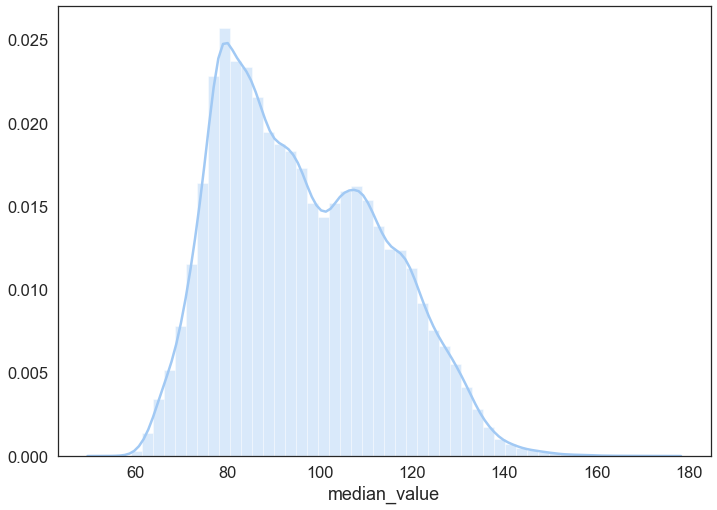

In [45]:
sns.distplot(df_not_combined.median_value);

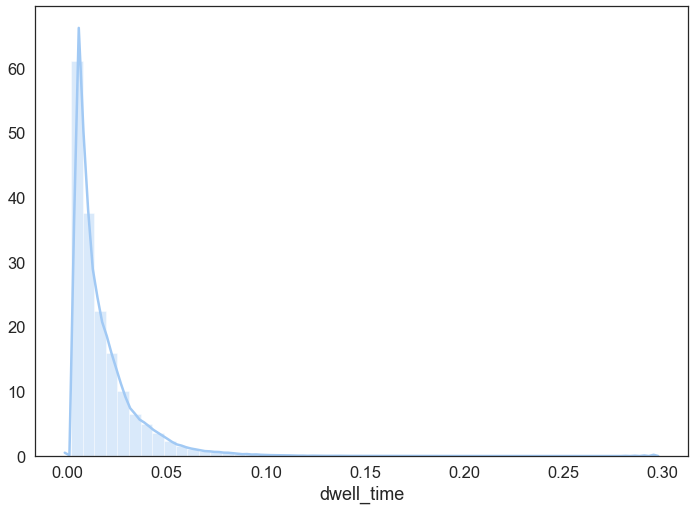

In [46]:
sns.distplot(df_not_combined.dwell_time);

## Association of measured data and base modification

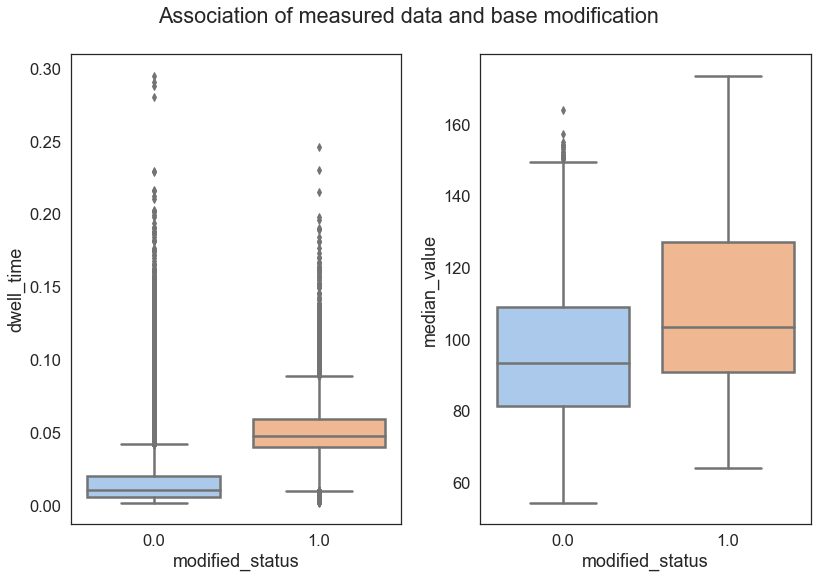

In [47]:
# simple boxplot to see if modified read_pos have different median and dwell time values

plt.subplot(1,2,1)
sns.boxplot(df.modified_status, df.dwell_time)
plt.subplot(1,2,2)
sns.boxplot(df.modified_status, df.median_value)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Association of measured data and base modification");

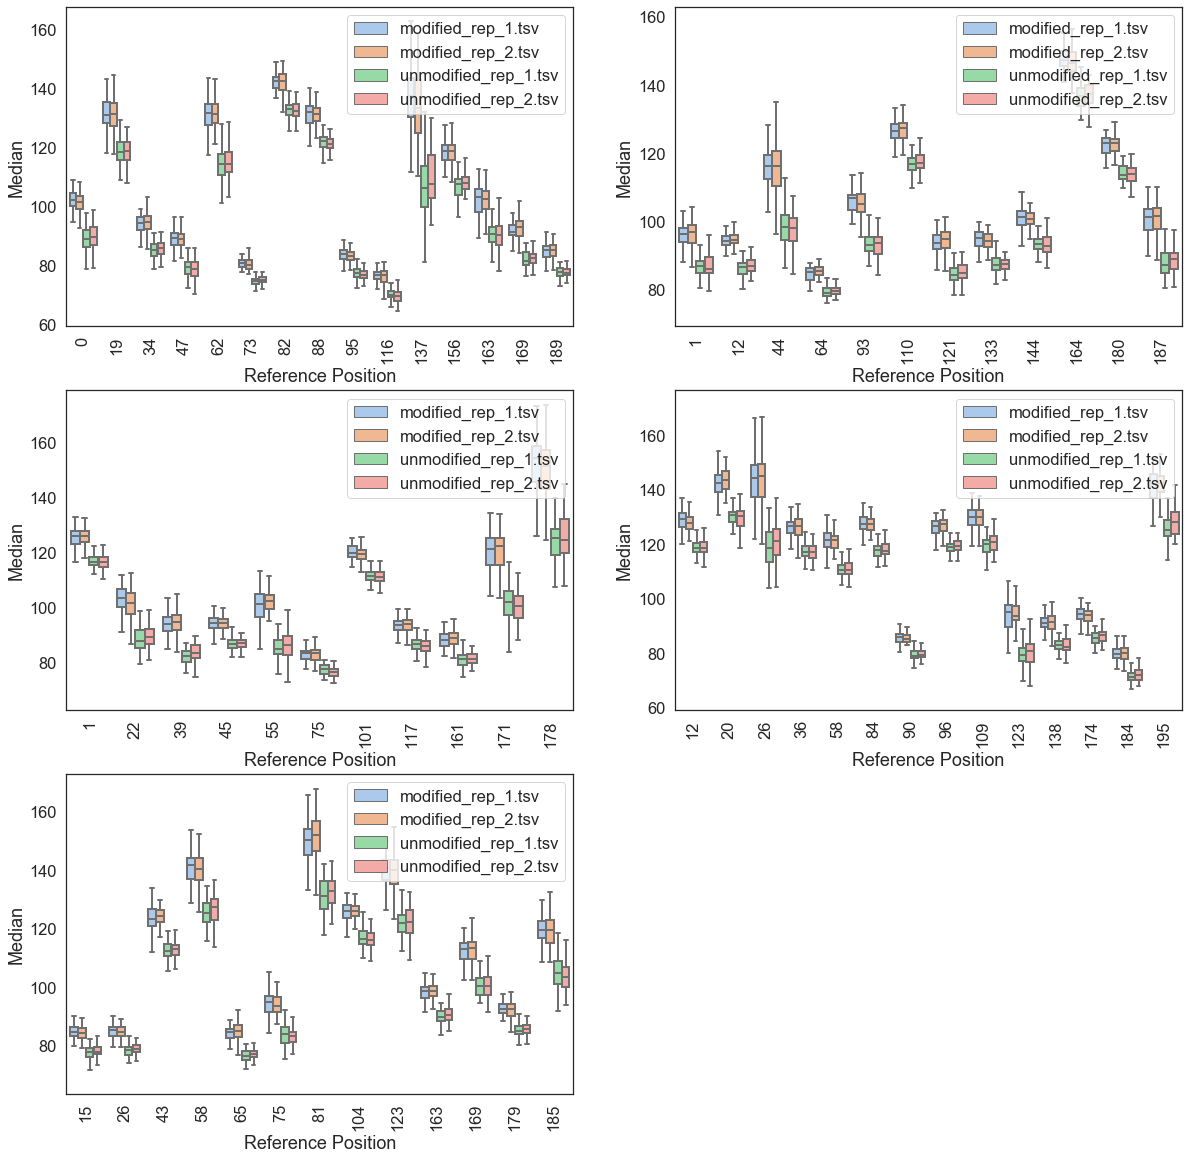

In [48]:
# plot of median value of every modified position for each file

plt.figure(figsize = (20,20))
for idx, elm in enumerate(df["ref_number"].unique()):
    temp = df[(df["ref_number"]==elm) & df["ref_pos"].isin(df[(df["ref_number"]==elm) & (df["modified_status"] == 1)].ref_pos.unique())]
    plt.subplot(3,2,idx + 1)
    sns.boxplot(x=temp.ref_pos, y=temp.median_value, hue=temp.file_name, dodge=True, linewidth=2,fliersize=0)
    plt.legend().set_visible(False)
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")
    plt.xlabel("Reference Position")
    plt.ylabel("Median");

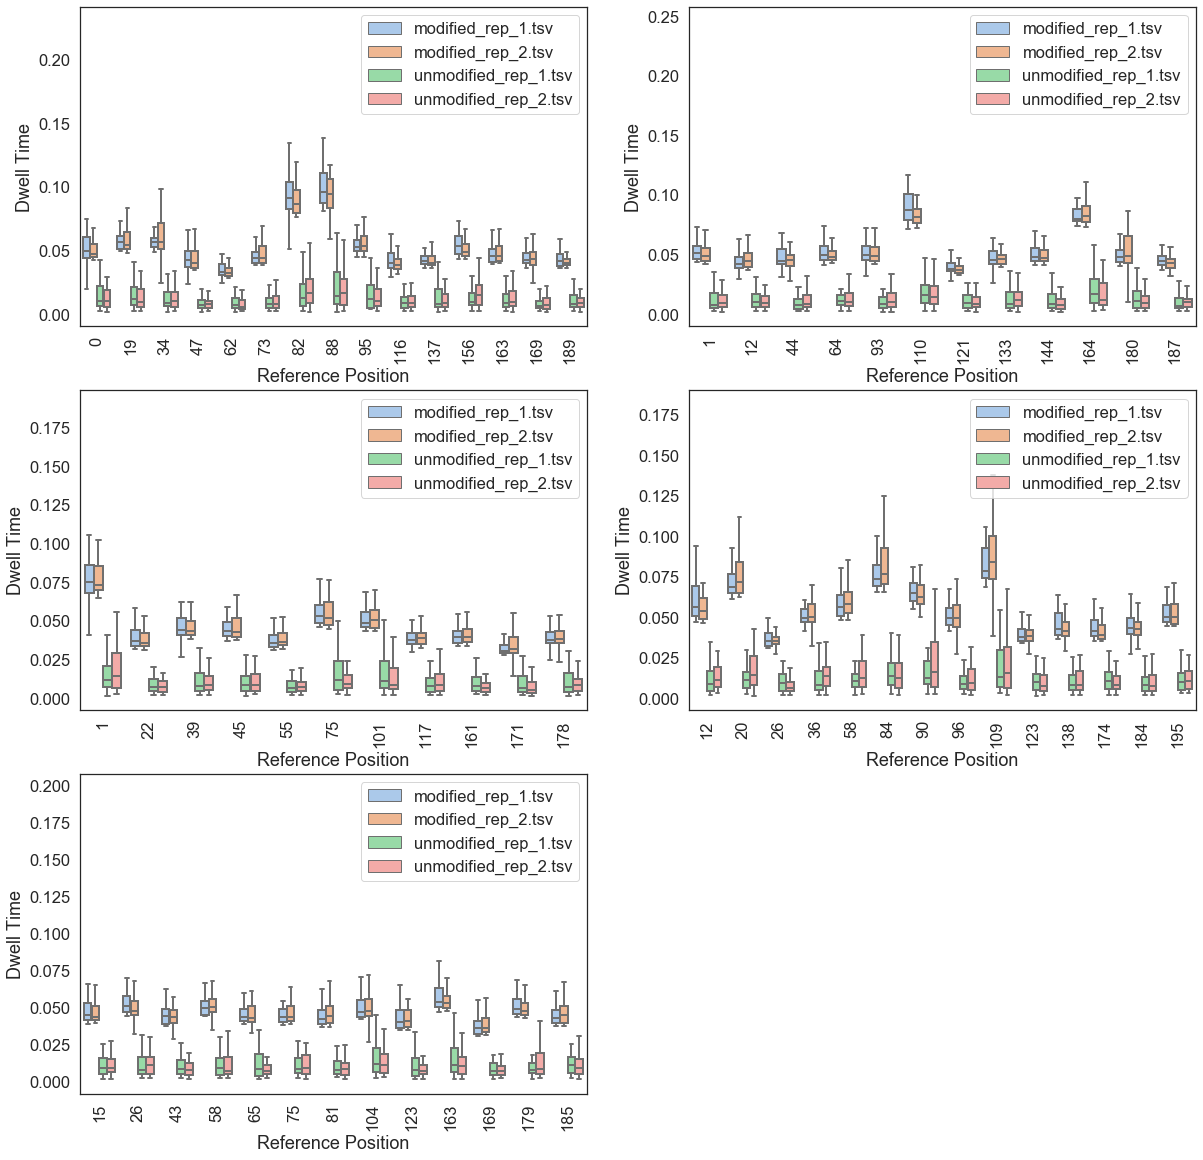

In [49]:
# plot of dwell_time of every modified position for each file

plt.figure(figsize = (20,20))
for idx, elm in enumerate(df["ref_number"].unique()):
    temp = df[(df["ref_number"]==elm) & df["ref_pos"].isin(df[(df["ref_number"]==elm) & (df["modified_status"] == 1)].ref_pos.unique())]
    plt.subplot(3,2,idx + 1)
    sns.boxplot(x=temp.ref_pos, y=temp.dwell_time, hue=temp.file_name, dodge=True, linewidth=2,fliersize=0)
    plt.legend().set_visible(False)
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")
    plt.xlabel("Reference Position")
    plt.ylabel("Dwell Time");

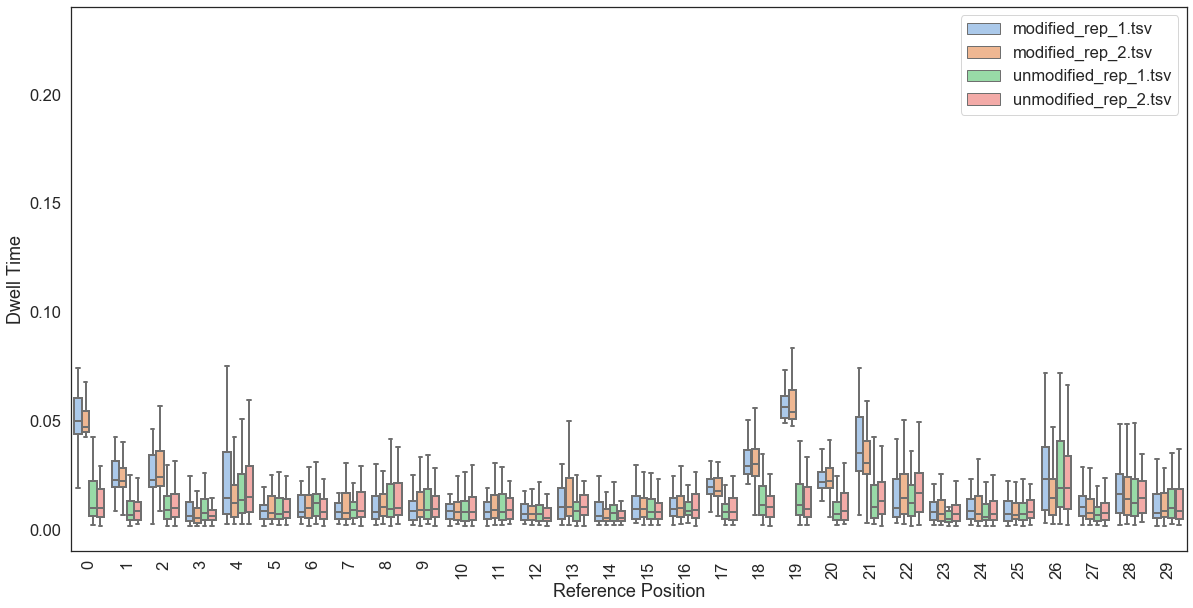

In [50]:
# example plot of the first 30 read_pos of one read of one ref_num to see if there is even a difference between modified 
# and unmodified

temp = df[(df["ref_number"]=='ref_0000') & df["ref_pos"].isin(df[(df["ref_number"]=='ref_0000')].ref_pos.unique()[:30])]
plt.figure(figsize = (20,10))
sns.boxplot(x=temp.ref_pos, y=temp.dwell_time, hue=temp.file_name, dodge=True, linewidth=2,fliersize=0)
plt.legend().set_visible(False)
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.xlabel("Reference Position")
plt.ylabel("Dwell Time");


=> here only positions 0 and 19 are considered modified, but there is a clear leakage to the positions +2 and -2

In [51]:
df_not_combined

ref_pos ref_kmer  dwell_time  median_value ref_number  \
0             0    AATGG    0.074466    108.450395   ref_0000   
1             1    ATGGG    0.021499    110.385196   ref_0000   
2             2    TGGGC    0.033993    108.417694   ref_0000   
3             3    GGGCT    0.005762    110.508778   ref_0000   
4             4    GGCTT    0.026592    112.052889   ref_0000   
...         ...      ...         ...           ...        ...   
225395      191    CGTGC    0.006416     91.601589   ref_0004   
225396      192    GTGCC    0.030970     82.289917   ref_0004   
225397      193    TGCCT    0.002183    102.220231   ref_0004   
225398      194    GCCTG    0.019195     72.236485   ref_0004   
225399      195    CCTGA    0.005675     93.791590   ref_0004   

                   file_name read_num modified_status base_1 base_2 base_3  \
0         modified_rep_1.tsv     #0_0             1.0      A      A      T   
1         modified_rep_1.tsv     #0_0             0.0      A      T      G   
2         modified_rep_1.tsv     #0_0             0.0      T      G      G   
3         modified_rep_1.tsv     #0_0             0.0      G      G      G   
4         modified_rep_1.tsv     #0_0             0.0      G      G      C   
...                      ...      ...             ...    ...    ...    ...   
225395  unmodified_rep_2.tsv    #4_59             0.0      C      G      T   
225396  unmodified_rep_2.tsv    #4_59             0.0      G      T      G   
225397  unmodified_rep_2.tsv    #4_59             0.0      T      G      C   
225398  unmodified_rep_2.tsv    #4_59             0.0      G      C      C   
225399  unmodified_rep_2.tsv    #4_59             0.0      C      C      T   

       base_4 base_5   file_type  dwell_time_rolling_median  \
0           G      G    modified                   0.033993   
1           G      G    modified                   0.027746   
2           G      C    modified                   0.026592   
3           C      T    modified                   0.021499   
4           T      T    modified                   0.008281   
...       ...    ...         ...                        ...   
225395      G      C  unmodified                   0.006416   
225396      C      C  unmodified                   0.006948   
225397      C      T  unmodified                   0.006416   
225398      T      G  unmodified                   0.012435   
225399      G      A  unmodified                   0.005675   

        median_value_rolling_median  dwell_time_rolling_min  \
0                        108.450395                0.021499   
1                        109.417796                0.005762   
2                        110.385196                0.005762   
3                        110.385196                0.005762   
4                        108.417694                0.005762   
...                             ...                     ...   
225395                    91.601589                0.002183   
225396                    82.289917                0.002183   
225397                    91.601589                0.002183   
225398                    88.040754                0.002183   
225399                    93.791590                0.002183   

        median_value_rolling_min  dwell_time_diff_to_median  \
0                     108.417694                   0.058231   
1                     108.417694                   0.005264   
2                     108.417694                   0.017758   
3                      79.882353                  -0.010473   
4                      79.882353                   0.010357   
...                          ...                        ...   
225395                 79.453407                  -0.002446   
225396                 72.236485                   0.022109   
225397                 72.236485                  -0.006678   
225398                 72.236485                   0.010334   
225399                 72.236485                  -0.003186   

        median_valu

In [52]:
# interactive scatter plot so i am able to look at dwell time and median value correlation for specific reads

@interact( ref_pos=list(range(1,198)), ref_num = list(df_not_combined.ref_number.unique()),file_pair = ["1","2"])
def ref_pos_scatterplot(ref_pos, ref_num, file_pair):
    sns.scatterplot(x = "median_value", y = "dwell_time", hue = "file_type"
                , data = df_not_combined[(df_not_combined["ref_pos"] == ref_pos) & (df_not_combined["ref_number"] == ref_num)
                                        & (df_not_combined["file_name"].isin(["modified_rep_" + file_pair + ".tsv", 
                                                                              "unmodified_rep_" + file_pair + ".tsv"]))])
    plt.yscale("symlog")
    plt.legend(loc="upper right");

interactive(children=(Dropdown(description='ref_pos', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

## Values neighboring modified Position

### Comparison of Absolute Values

In [53]:
# plotting function to plot values for each modified read and neighbouring reads averaging over file types

def plot_modified_pos(ref_name, value,num_col = 3):
    
    # create mask for specified ref_num, specifically only getting modified ref_pos
    msk = df_not_combined[(df_not_combined["ref_number"]==ref_name)\
                          & (df_not_combined["modified_status"] == 1)].ref_pos.unique()
    #dynamic construction of figsize according to number of plots and cols
    plt.figure(figsize = (20,(len(msk)*8)/(num_col**1.3)))
    # for loop to go through every ref_pos in the ref_number (dna sequence)
    for idx, elm in enumerate(msk):
        # dynamic creation of subplot grid accroding to plot number and number of cols
        plt.subplot(math.ceil(len(msk)/num_col),num_col,idx + 1)
        # specific case if modified read is at the beginning
        if elm - 3 < 0:
            ra_min = 0
            plt.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2)
        else:
            ra_min = elm - 3
            # axvspan for highlight of modified position
            plt.axvspan(2.5, 3.5, color='red', alpha=0.2)
        #define ra min and ra max according to read_pos to be able to plot neighbouring positions
        ra_max = elm+4
        # create temp dataframe of the currently analysed position (as defined by ra_max and ra_min)
        temp = df_not_combined[(df_not_combined["ref_number"]==ref_name) & df_not_combined["ref_pos"]\
               .isin(df_not_combined[(df_not_combined["ref_number"]==ref_name)].ref_pos.unique()[ra_min:ra_max])]
        # create boxplot of temp data frame, seperate by file type and y axis is specified value
        sns.boxplot(x="ref_pos", y=value, hue="file_type",data=temp, dodge=True, linewidth=3,fliersize=0)
        plt.title("Modified Position "+str(elm))
        plt.xticks(rotation=90)
        plt.legend(loc="upper right")
        plt.xlabel("Reference position")
        plt.ylabel(value.replace("_"," ").capitalize())
    plt.tight_layout()
    plt.subplots_adjust(top=1-num_col/50)
    plt.suptitle(ref_name);

#### Dwell Time

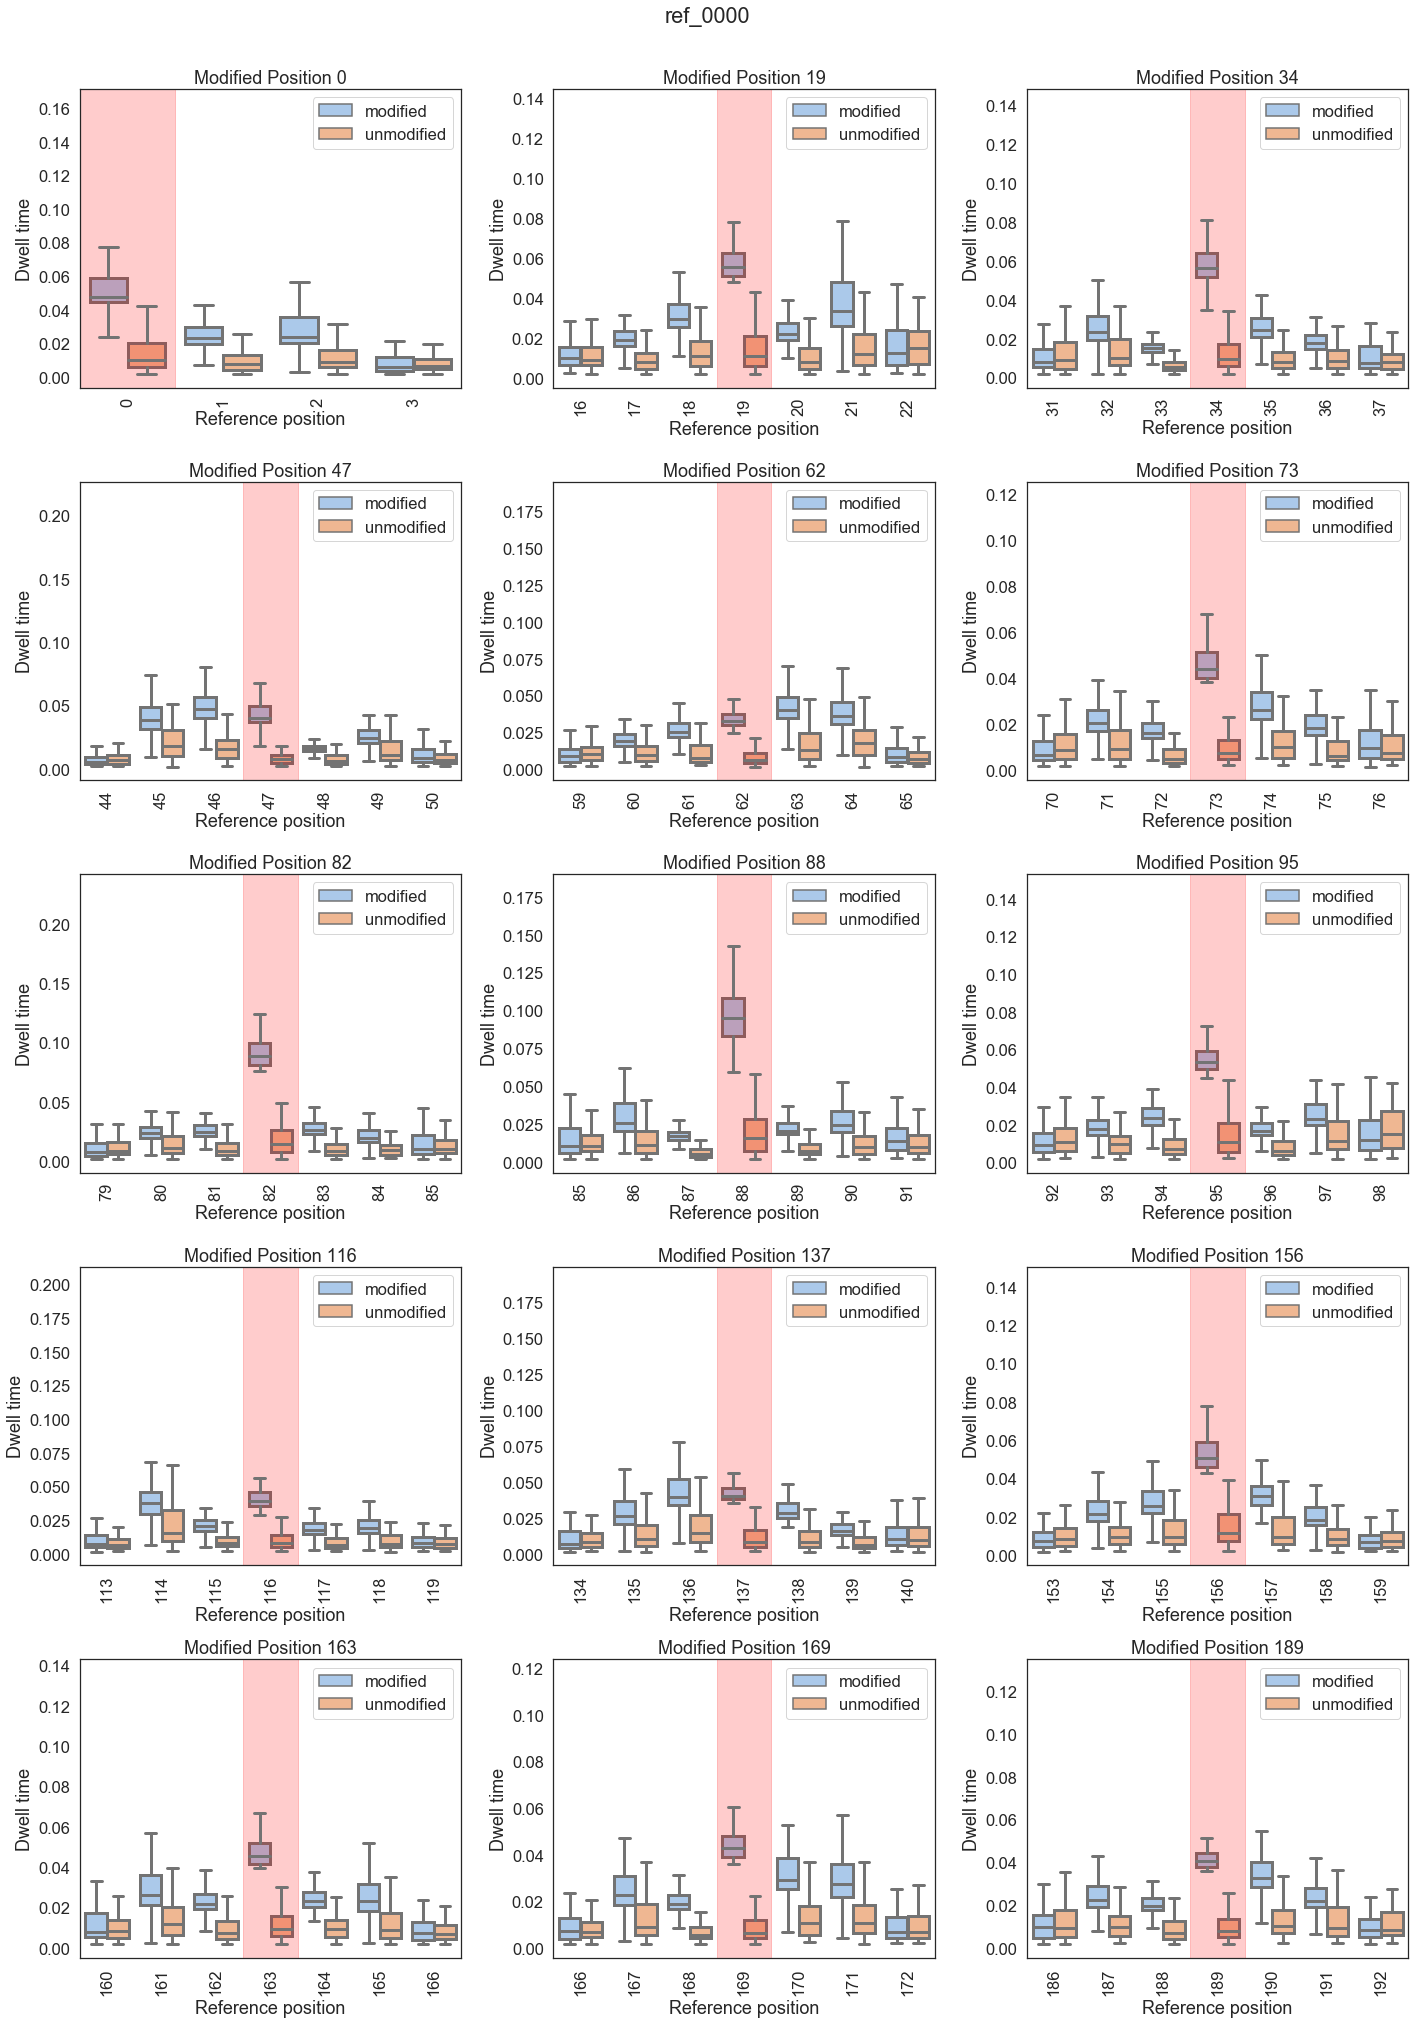

In [54]:
plot_modified_pos("ref_0000", "dwell_time")   

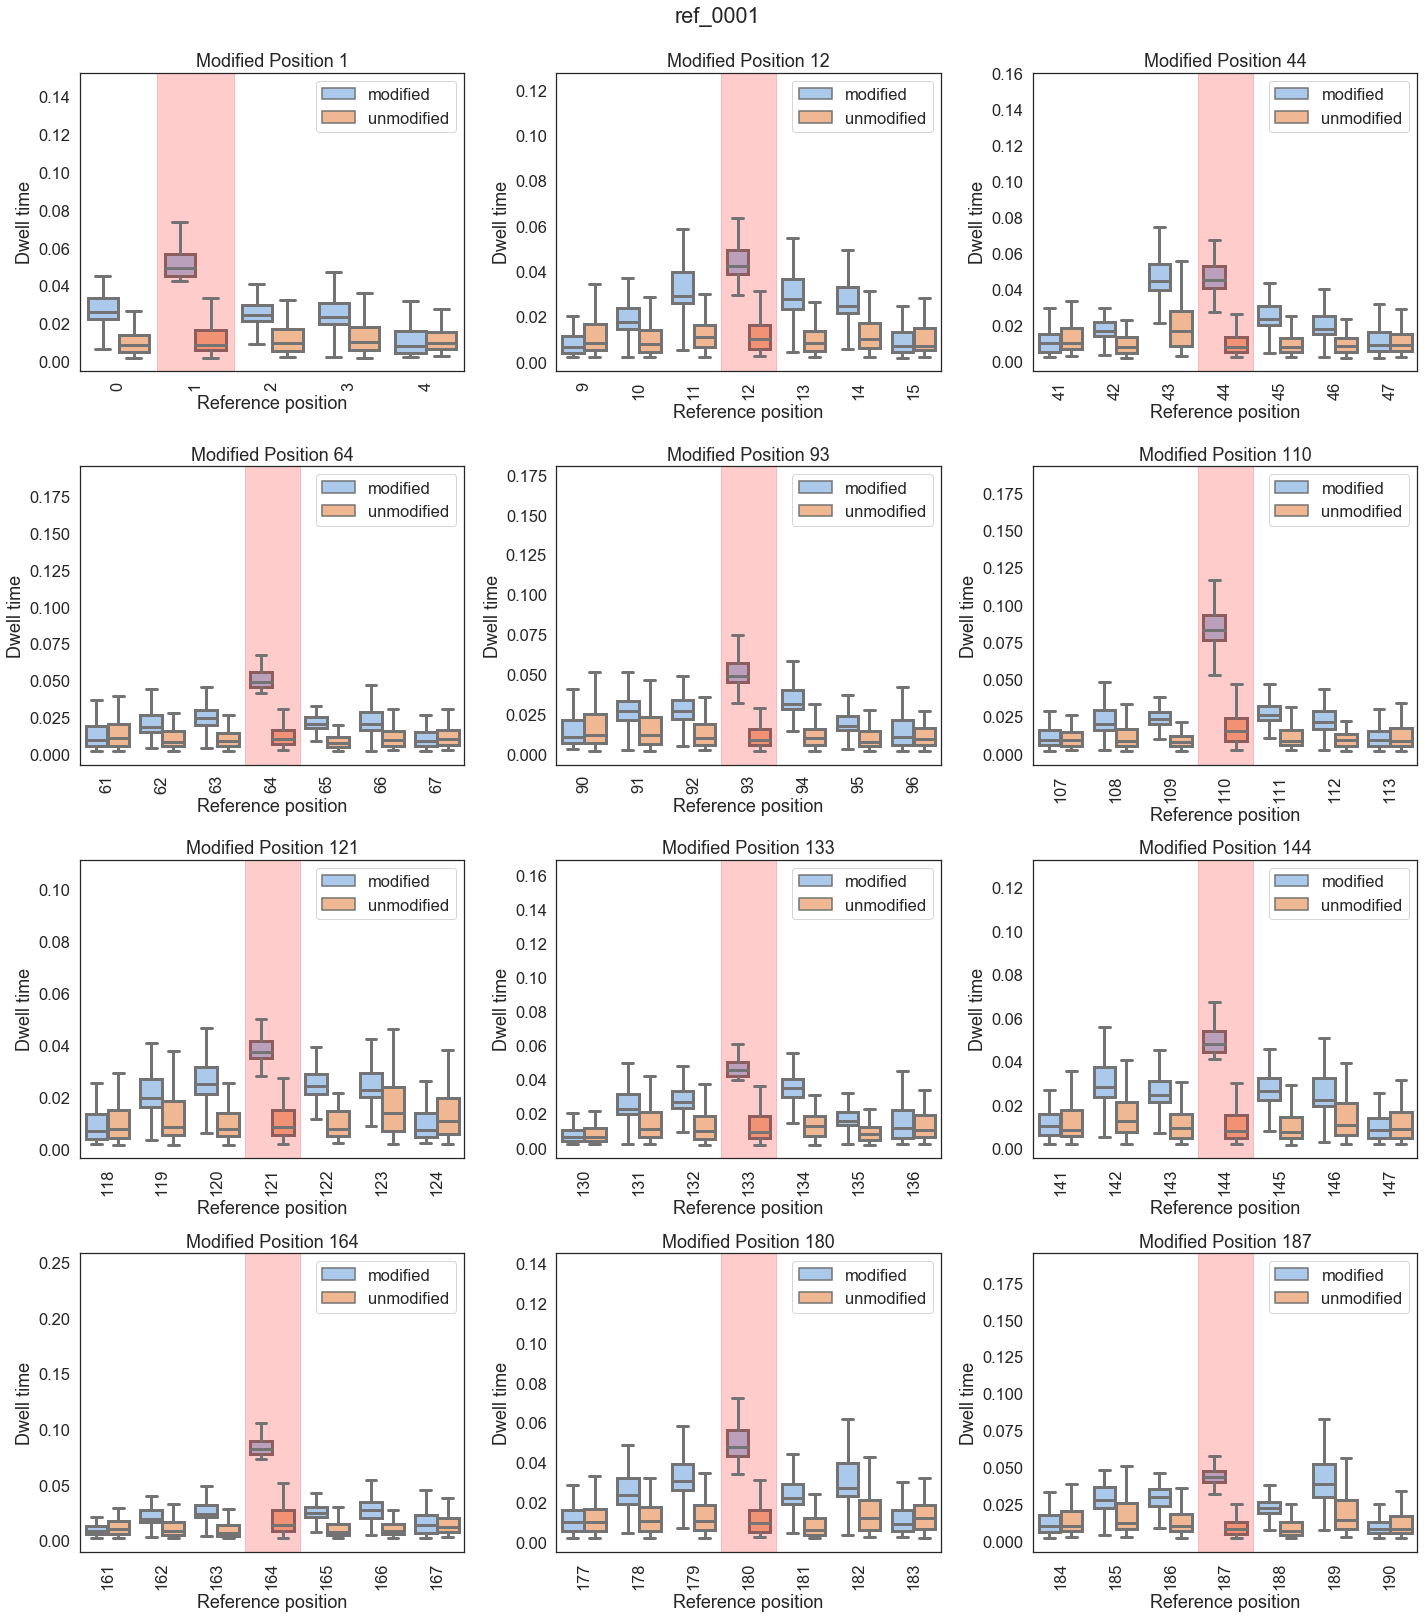

In [55]:
plot_modified_pos("ref_0001", "dwell_time")

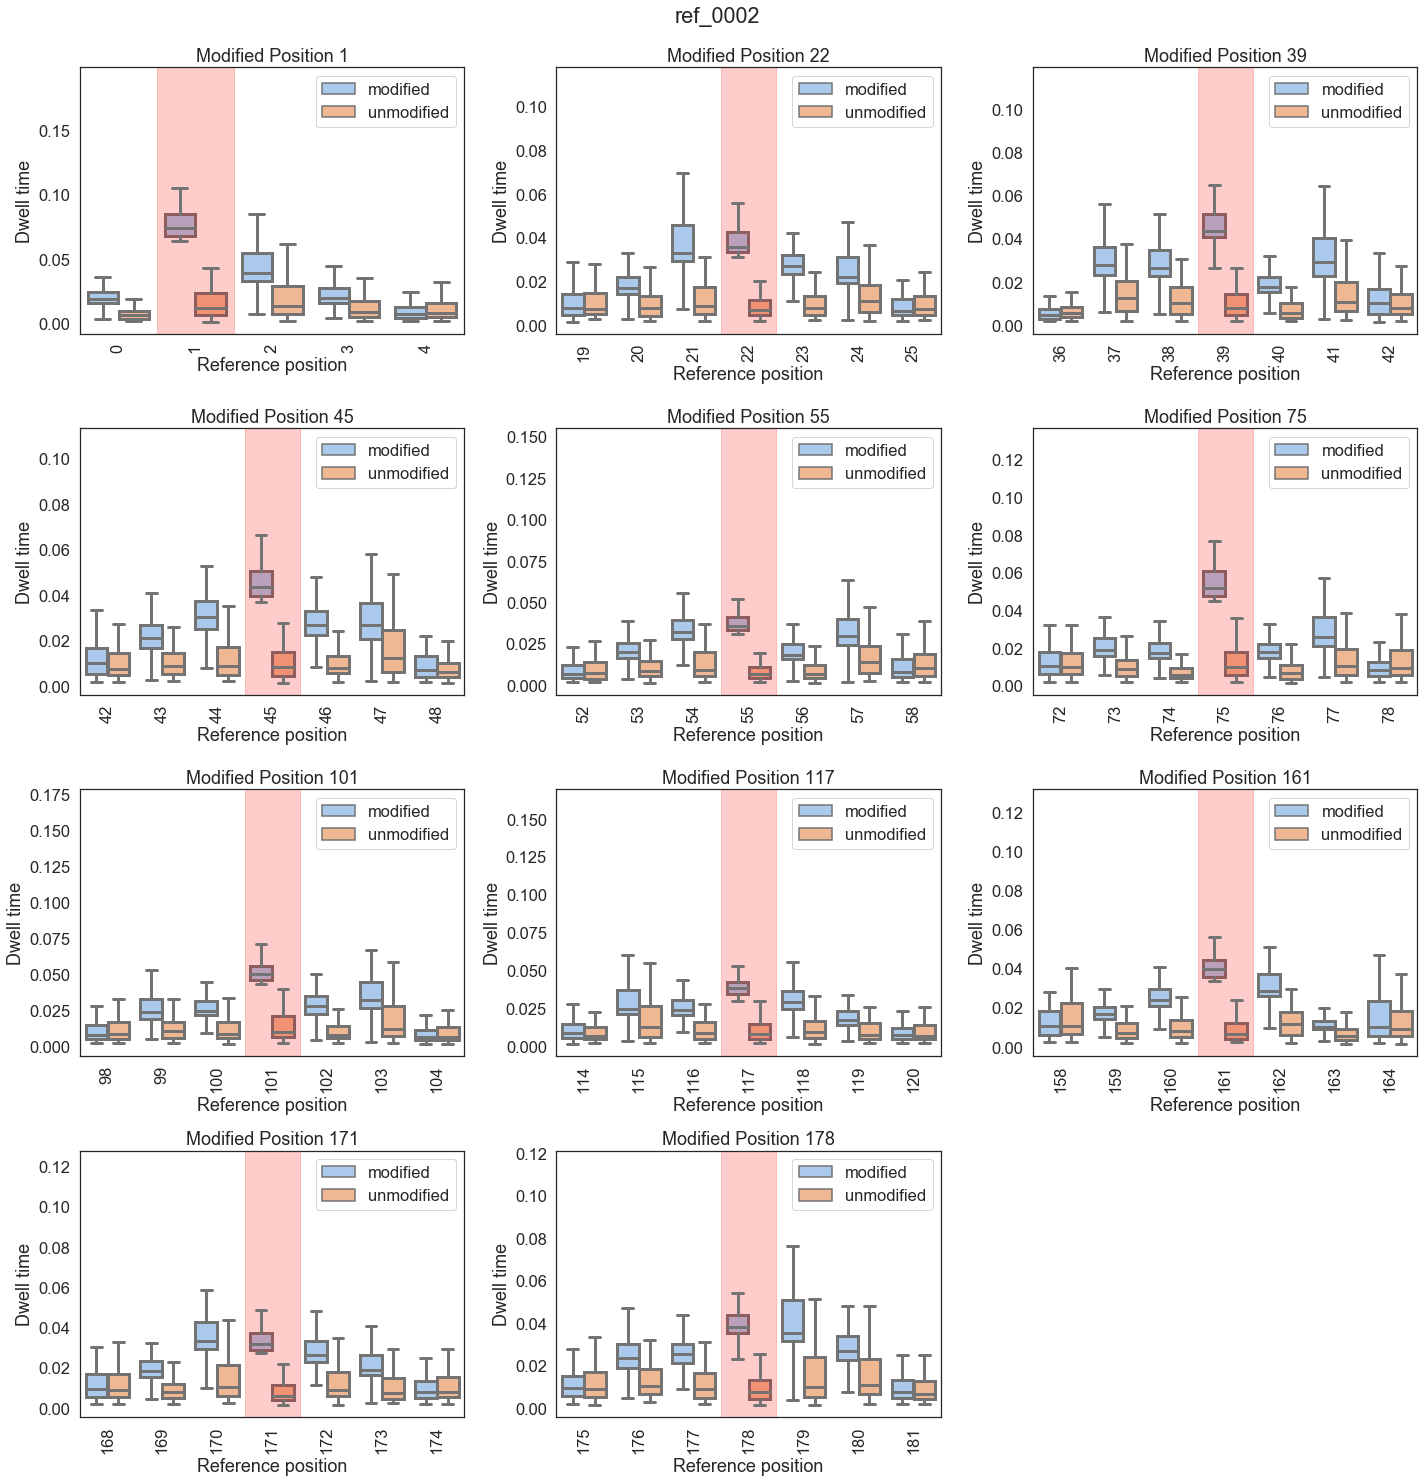

In [56]:
plot_modified_pos("ref_0002", "dwell_time")

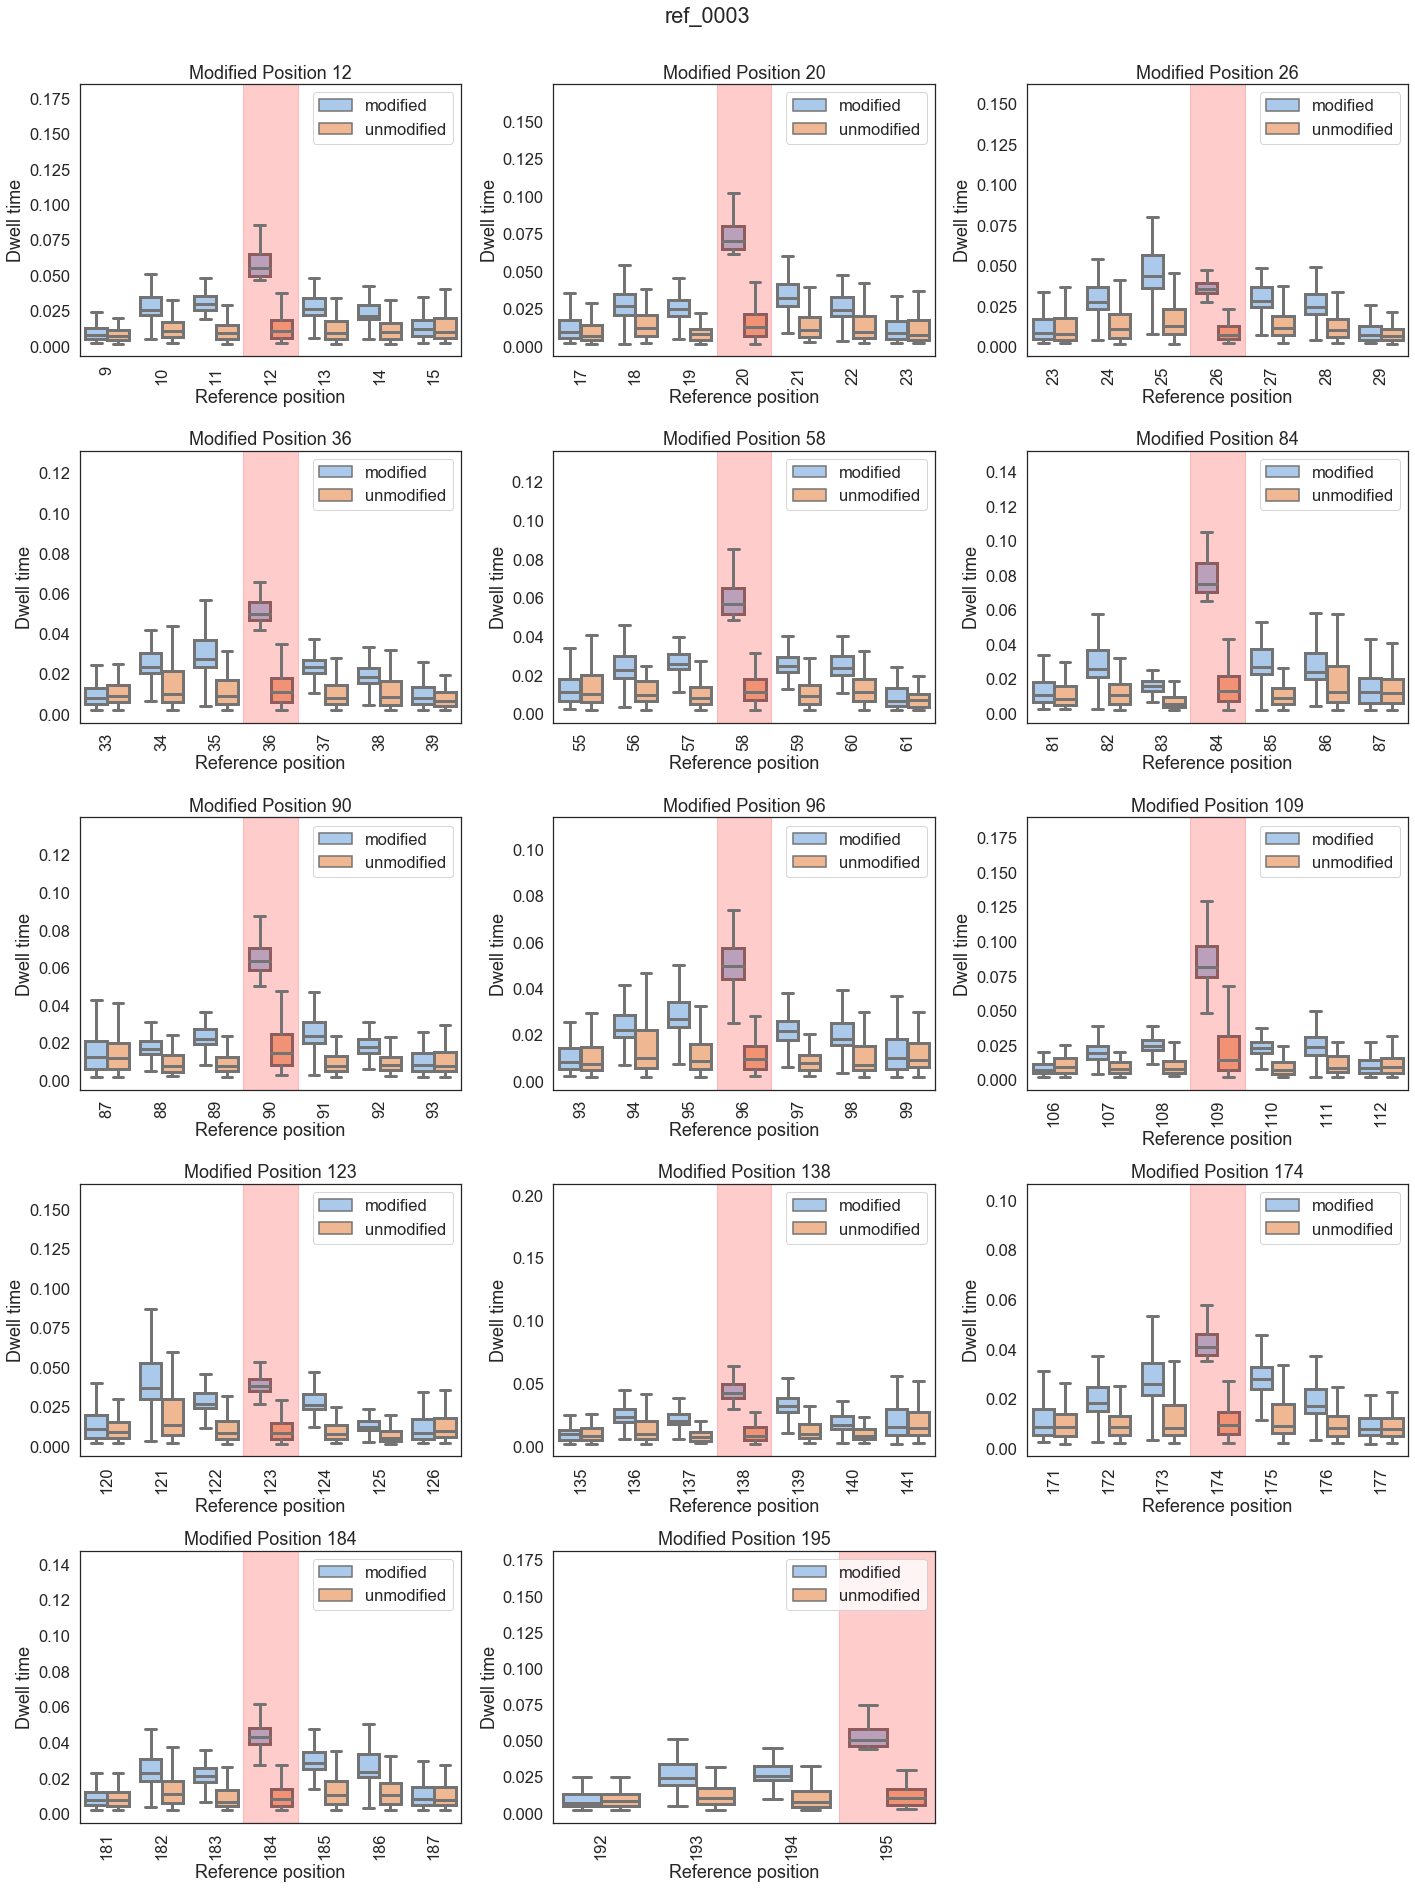

In [57]:
plot_modified_pos("ref_0003", "dwell_time")

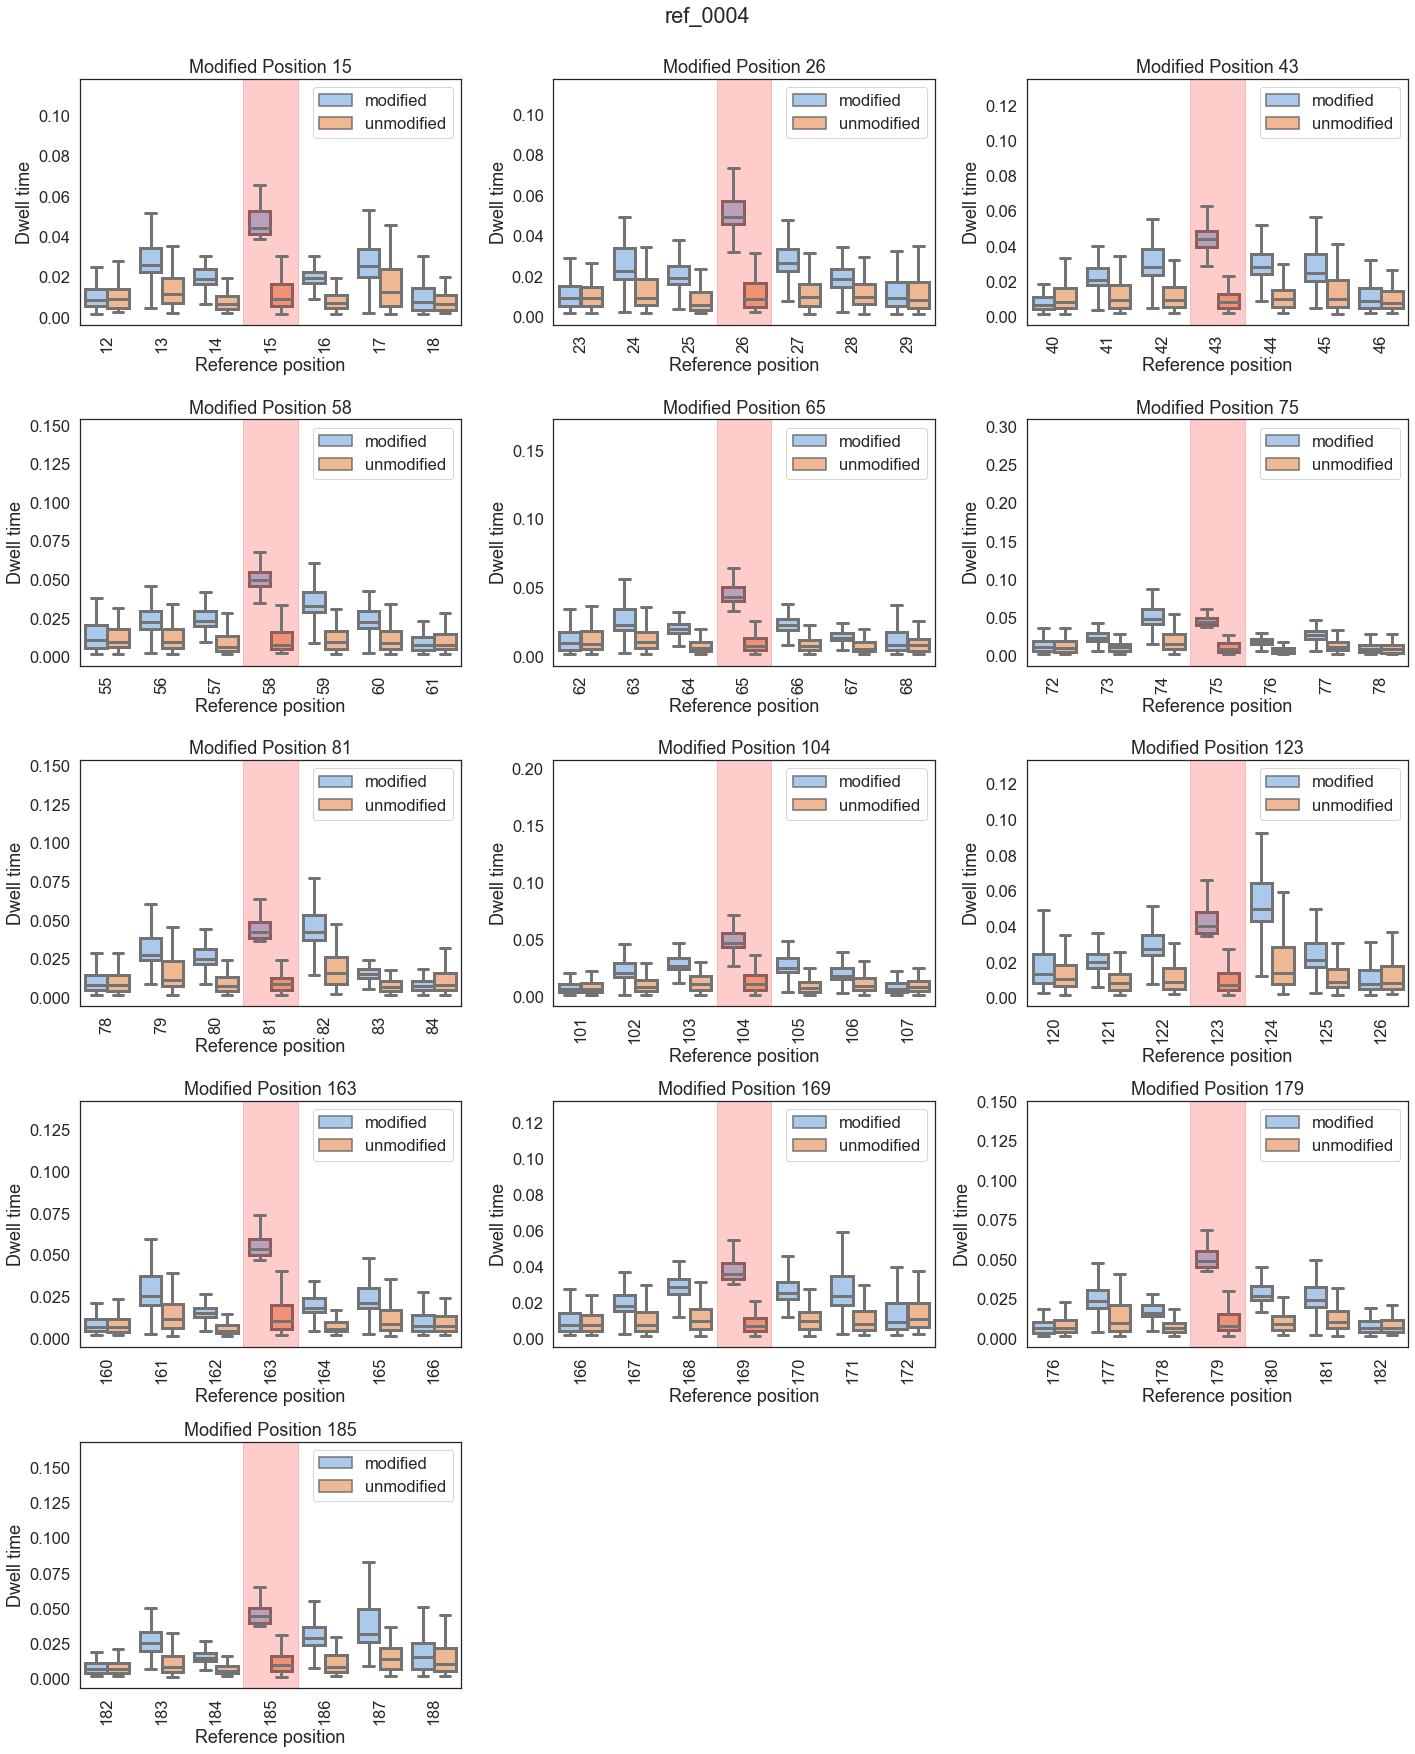

In [58]:
plot_modified_pos("ref_0004", "dwell_time")

#### median value

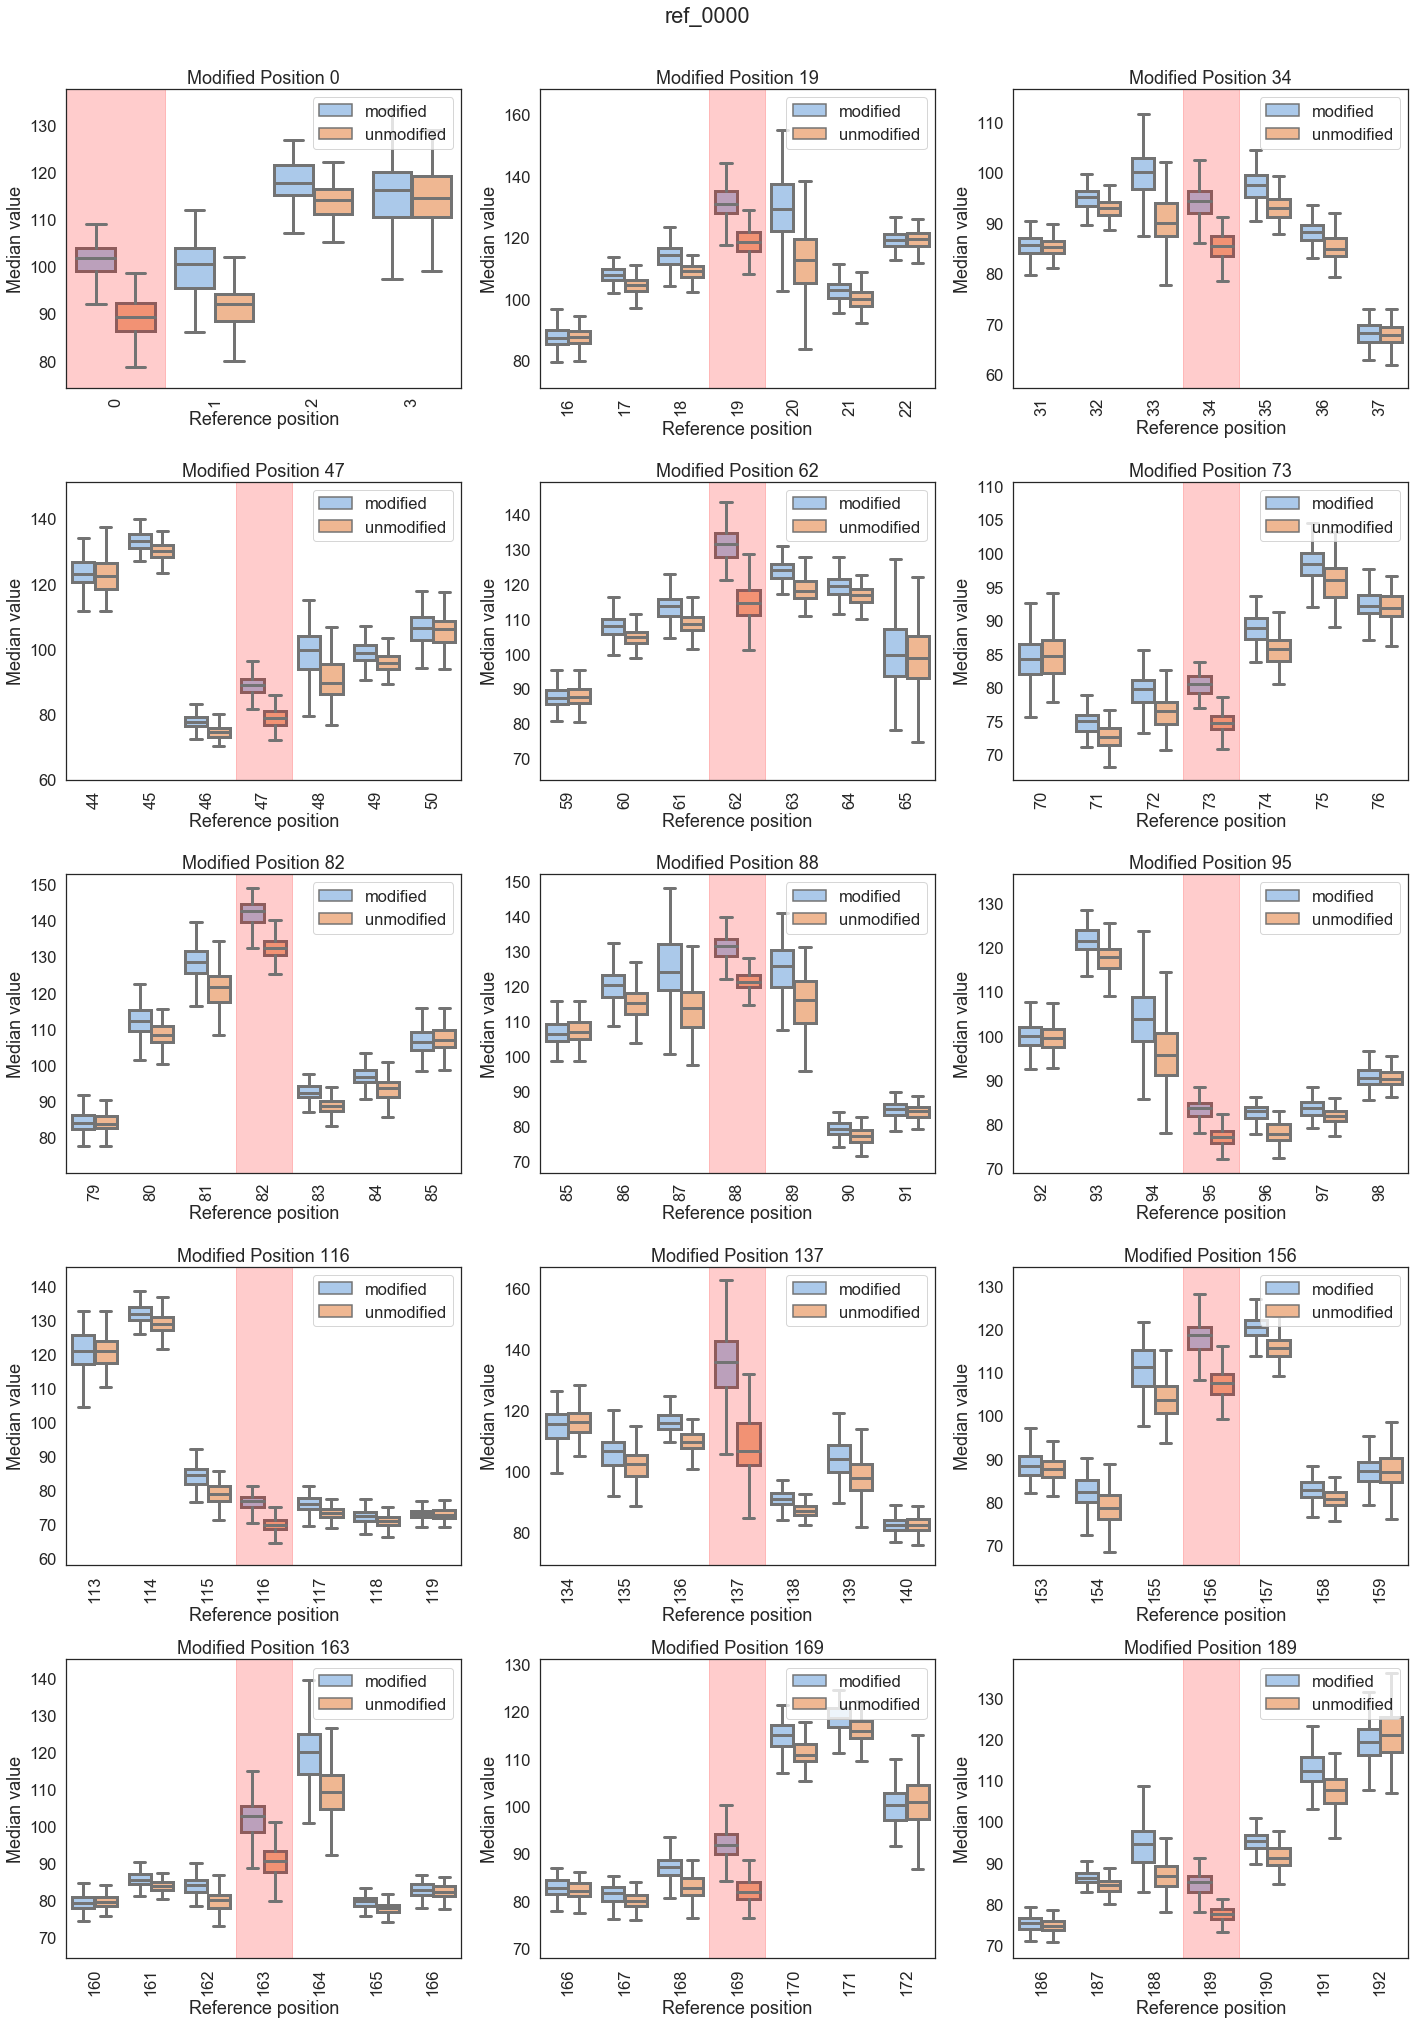

In [59]:
plot_modified_pos("ref_0000", "median_value")   

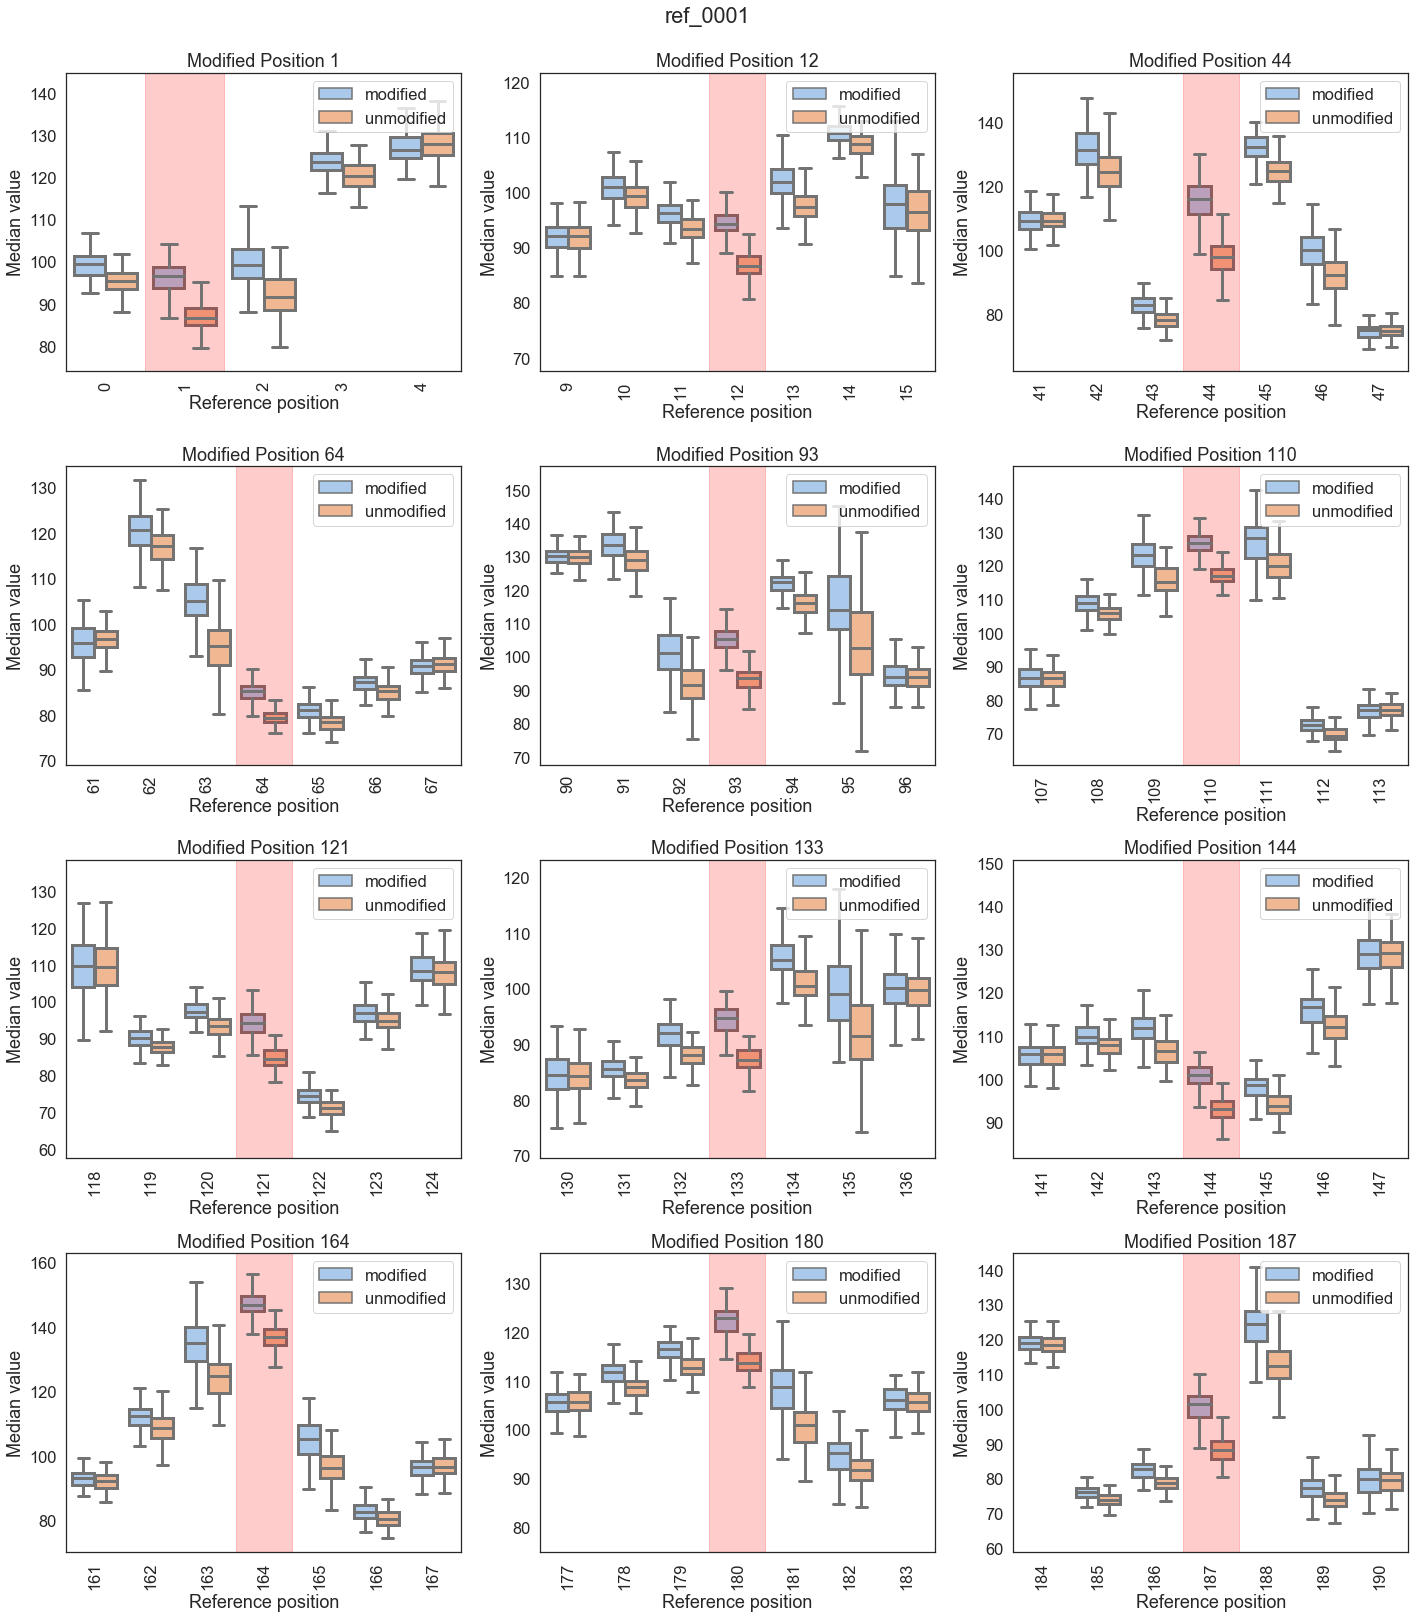

In [60]:
plot_modified_pos("ref_0001", "median_value")

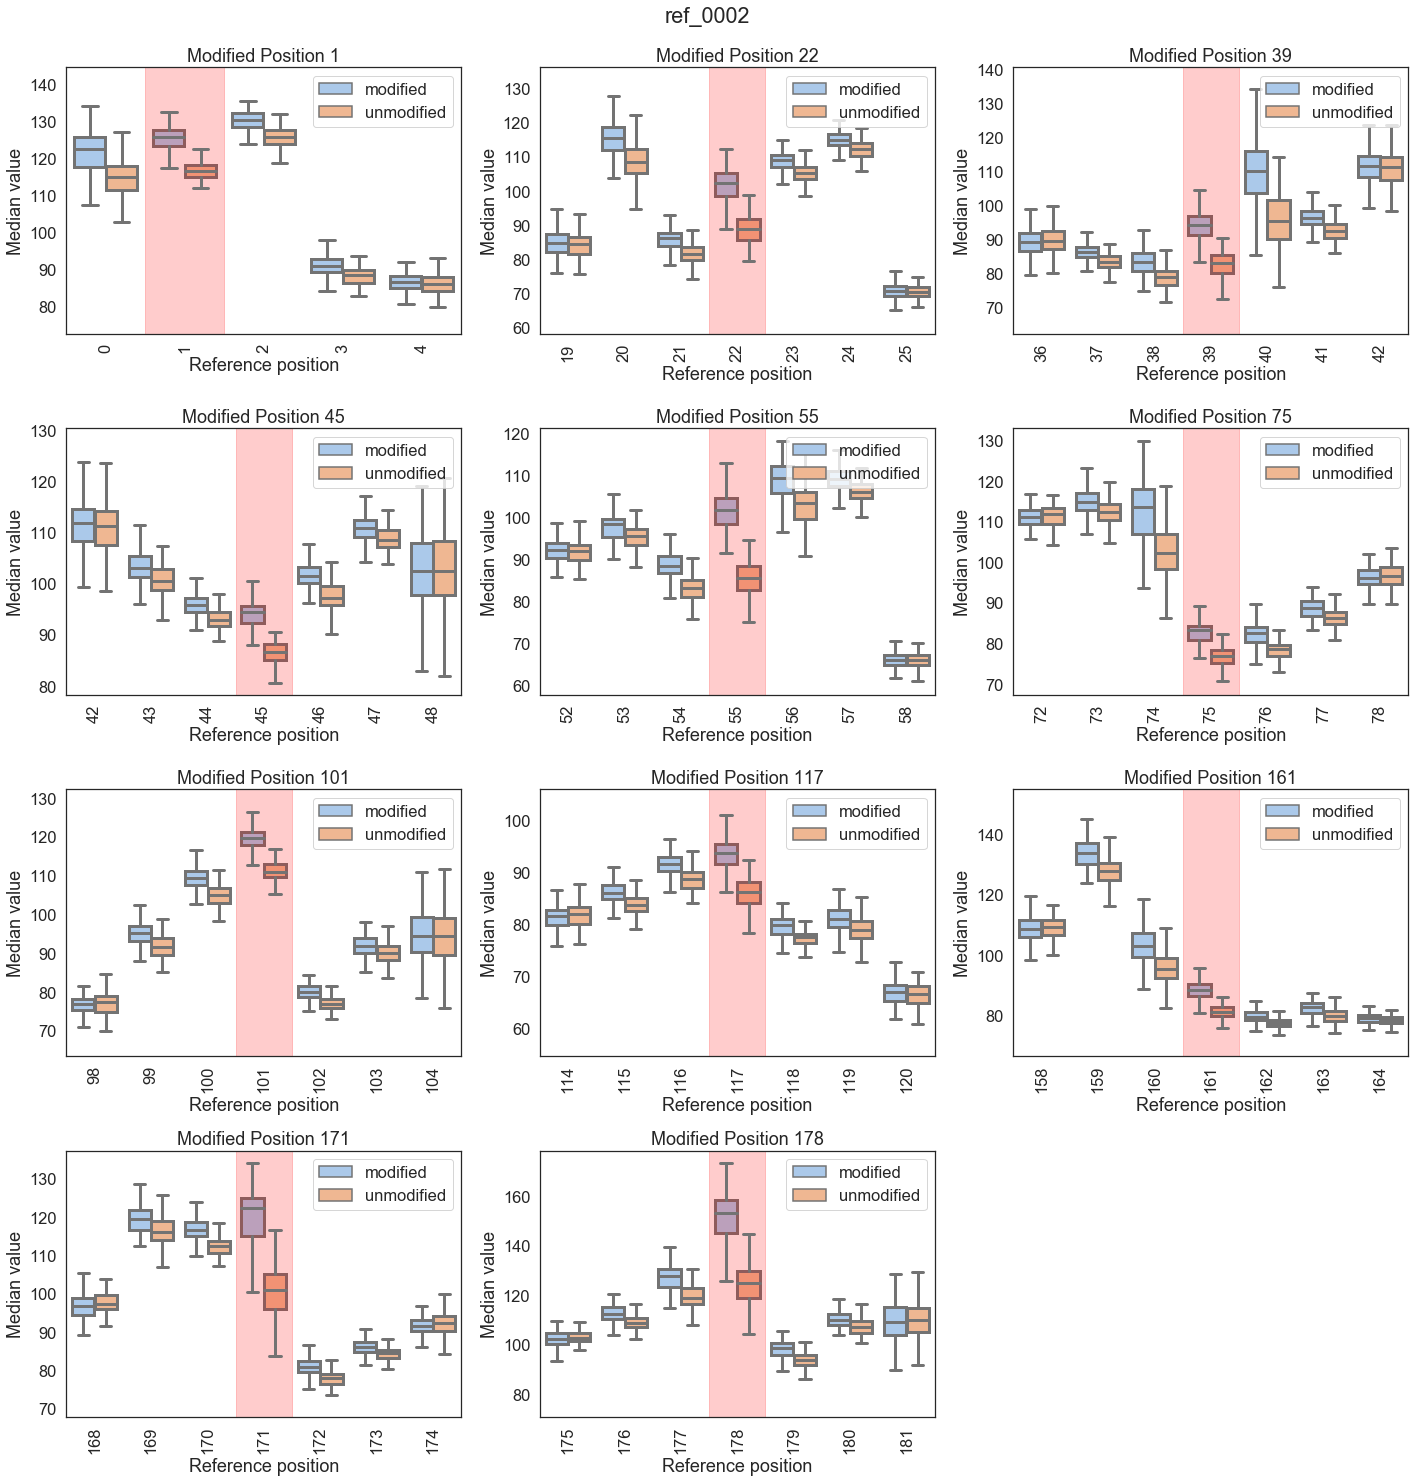

In [61]:
plot_modified_pos("ref_0002", "median_value")

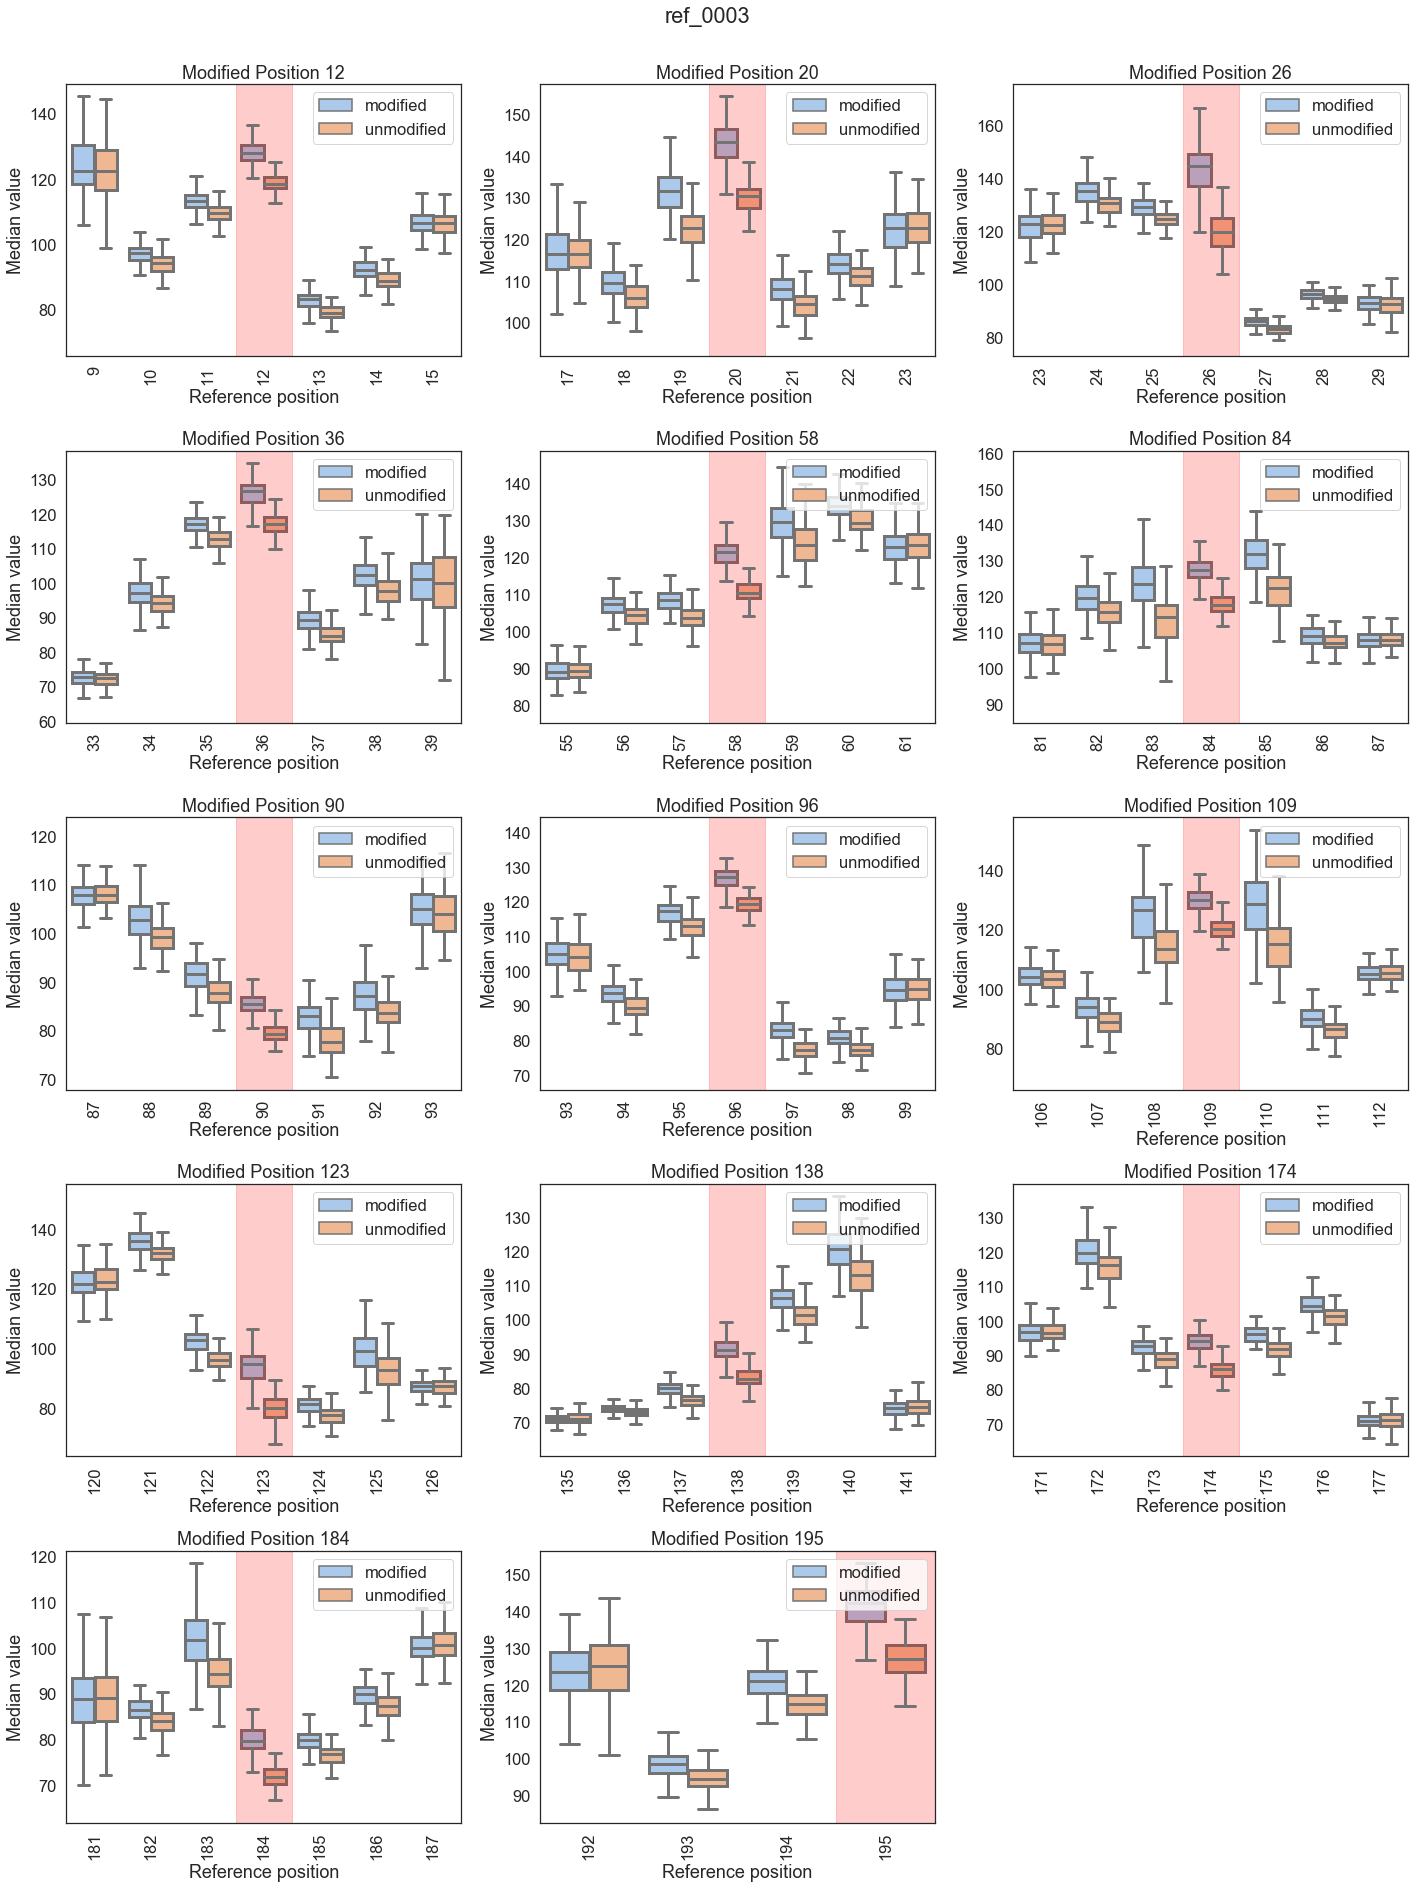

In [62]:
plot_modified_pos("ref_0003", "median_value")

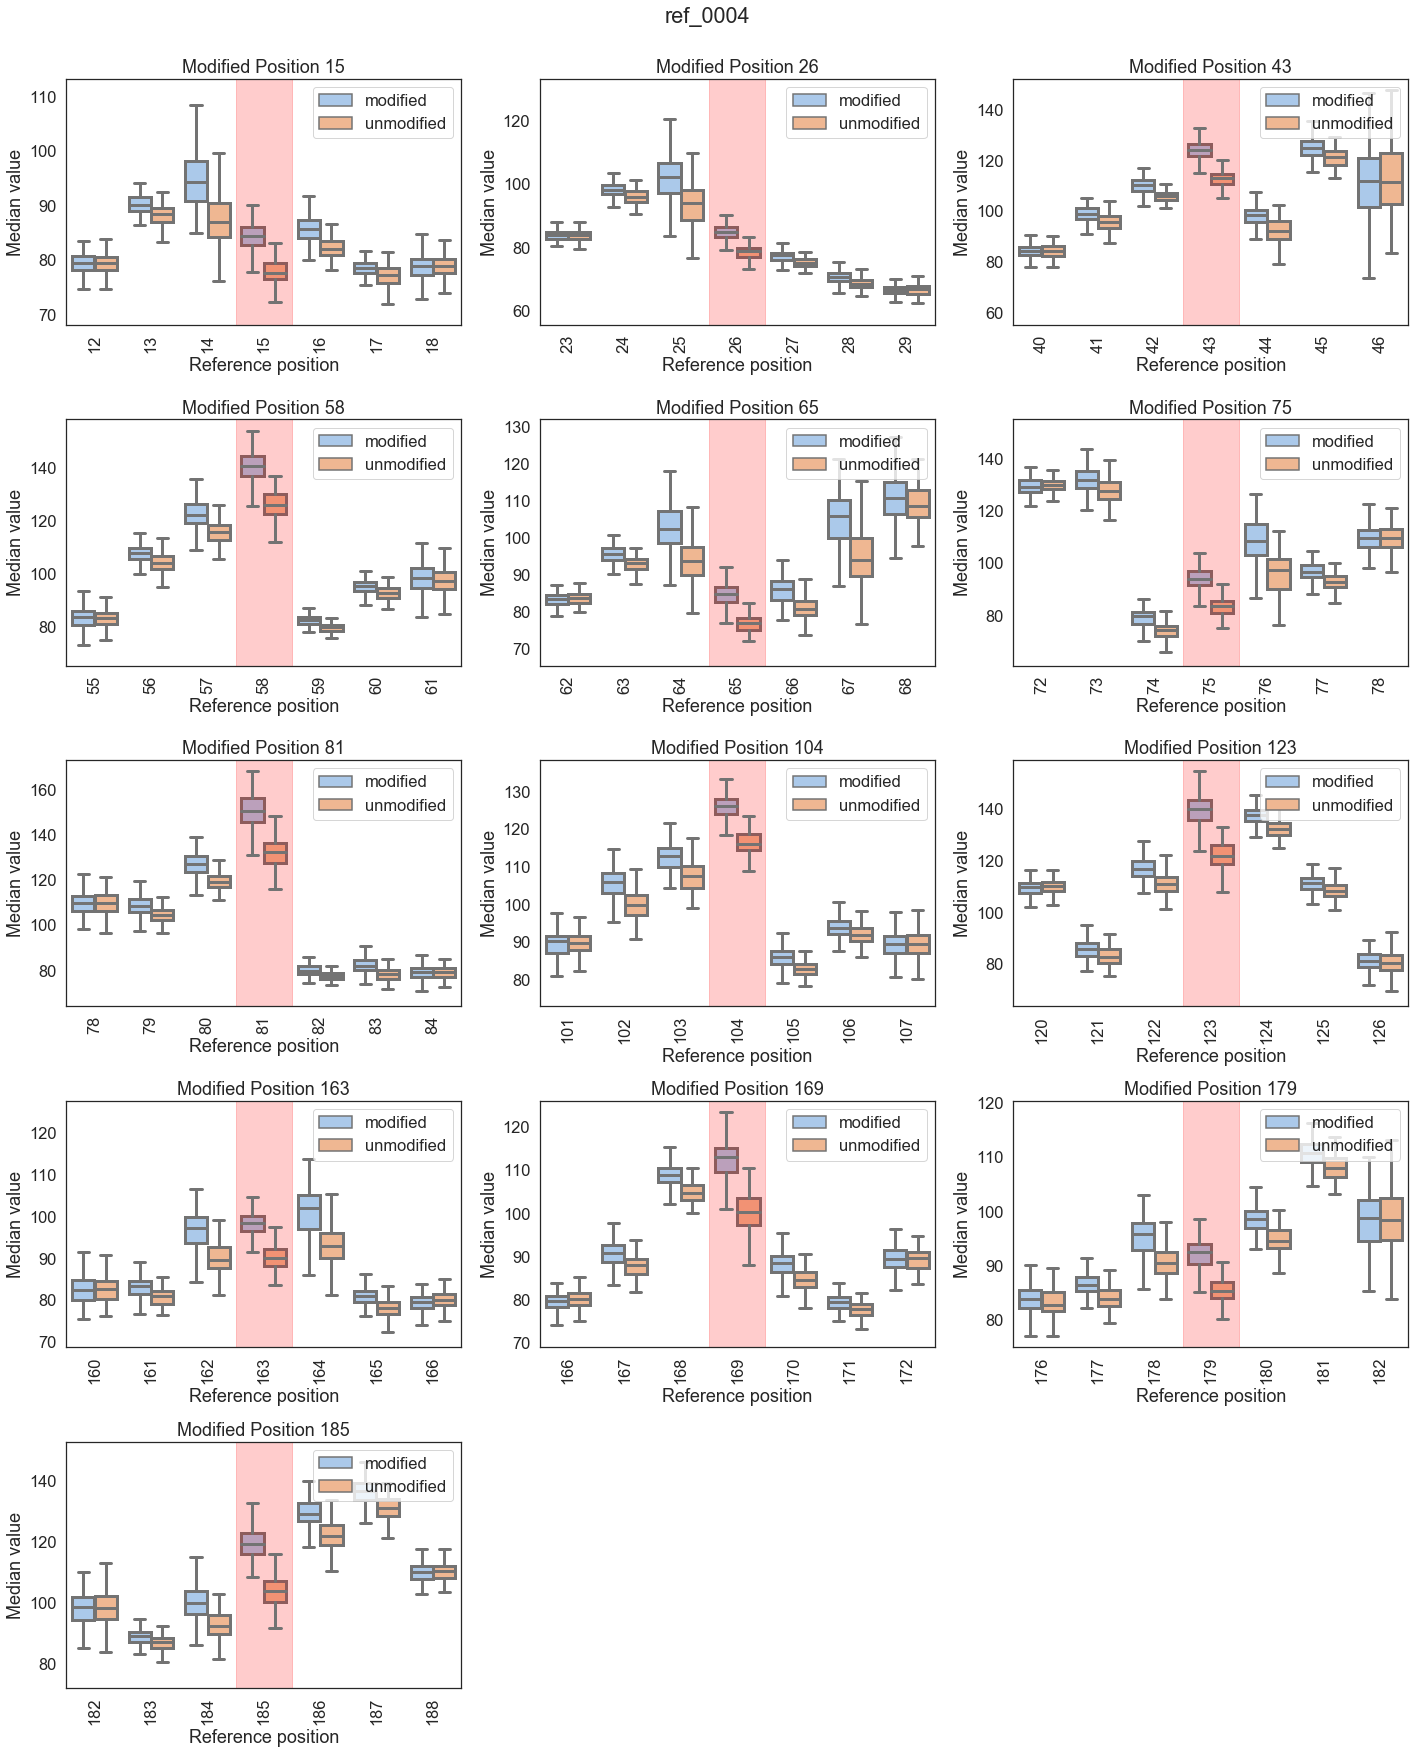

In [63]:
plot_modified_pos("ref_0004", "median_value")

### ratios

In [64]:
# here i want to create ratios of the measured values from modified to corresponding unmodified reads,
# to see if the ratio is higher if the modified base is in the middle

def plot_modified_pos_ratio(ref_name, value, num_col = 5):
    
    # first steps are the same as in first plotting function
    msk = df_not_combined[(df_not_combined["ref_number"]==ref_name) & (df_not_combined["modified_status"] == 1)].ref_pos.unique()
    plt.figure(figsize = (20,(len(msk)*8)/(num_col**1.3)))
    for idx, elm in enumerate(msk):
        plt.subplot(math.ceil(len(msk)/num_col),num_col,idx + 1)
        if elm - 3 < 0:
            ra_min = 0
            plt.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2)
        else:
            ra_min = elm - 3
            plt.axvspan(2.5, 3.5, color='red', alpha=0.2)
        ra_max = elm +4
            
        temp = df_not_combined[(df_not_combined["ref_number"]==ref_name) & df_not_combined["ref_pos"]\
               .isin(df_not_combined[(df_not_combined["ref_number"]==ref_name)].ref_pos.unique()[ra_min:ra_max])]
        
        # group by ref pos and file type and get the median
        temp_msk = temp.groupby(["ref_pos","file_type"]).median().reset_index()
        
        # for each pos in ra min to ra max (which are the positions +3 and -3 of the modified positions)
        # divide the median of the modified files by the median of the corresponding unmodified files
        res = [(np.mean(temp_msk[(temp_msk["file_type"] == "modified") & (temp_msk["ref_pos"] == i)][value])\
                /np.mean(temp_msk[(temp_msk["file_type"] == "unmodified") & (temp_msk["ref_pos"] == i)][value])) for i in range(ra_min,ra_max)]
        
        # create coords for plotting
        coord = list(np.arange(ra_min,ra_max))
        #remove nans from res, as these are the ones at the end where there are not positions anymore
        res = [i for i in res if str(i) != "nan"]
        #adjust coords for removed nans
        coord = coord[:len(res)]
        #barplot for ratios, as they are singular values
        sns.barplot(y=res, x=coord, edgecolor="grey", linewidth =4)
        plt.title("Modified Position "+str(elm))
        plt.xticks(rotation=90)
        plt.xlabel("Reference Position")
        plt.ylabel(value.replace("_"," ").capitalize())
        plt.ylim(min(res)-np.std(res)/3, max(res)+np.std(res)/3)
    plt.tight_layout()
    plt.subplots_adjust(top=1-num_col/50)
    plt.suptitle(ref_name);

#### Dwell Time

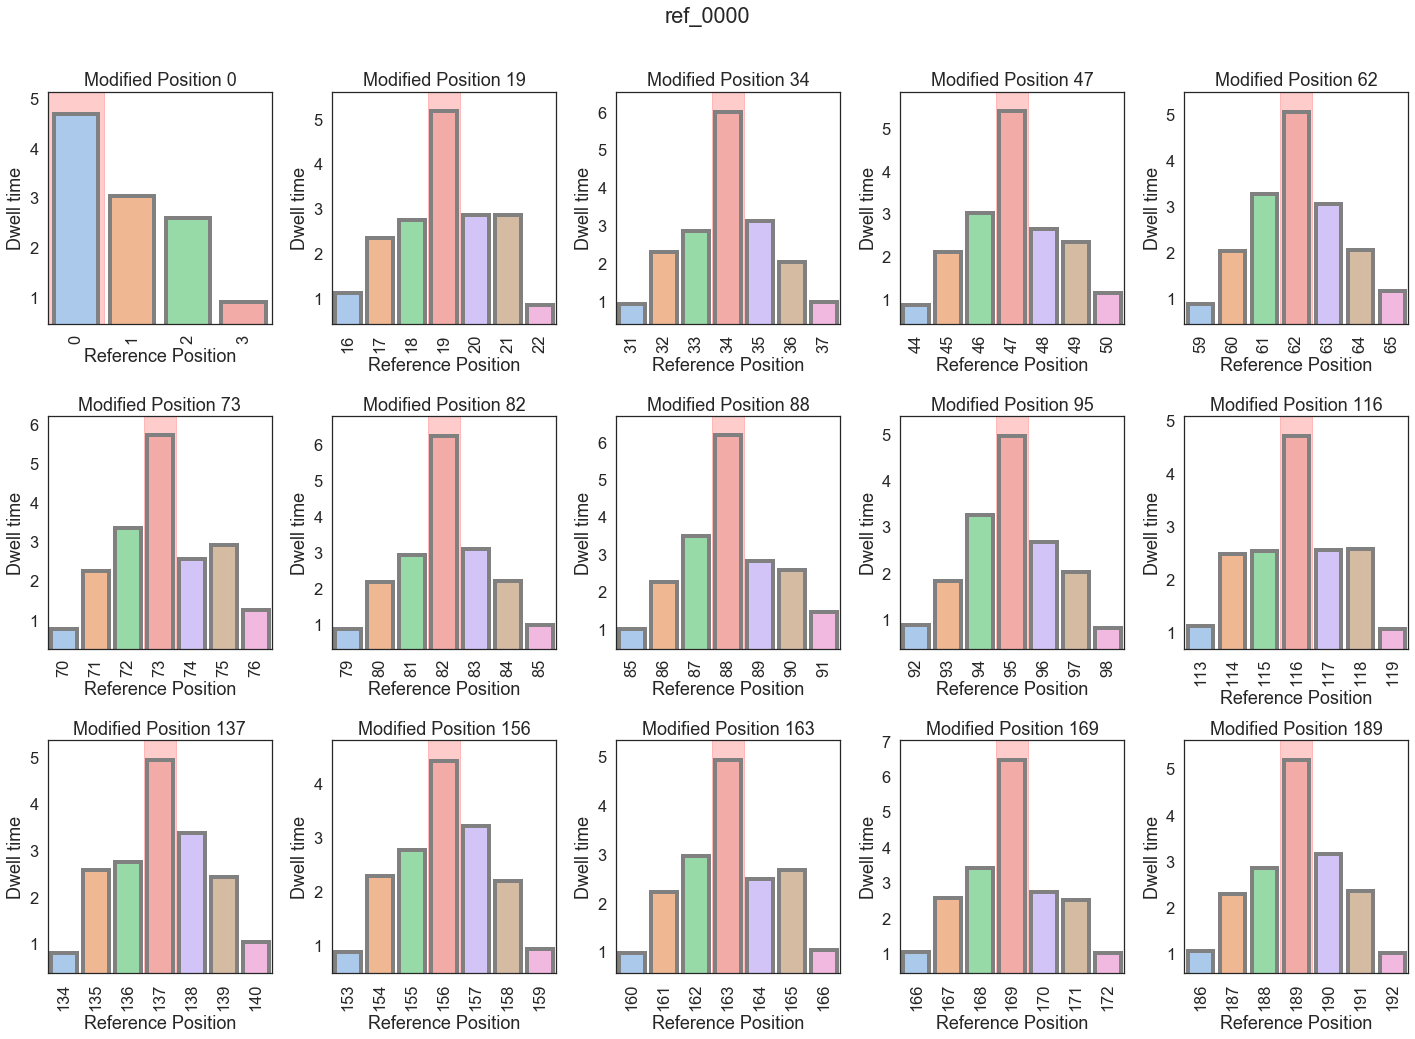

In [65]:
plot_modified_pos_ratio("ref_0000", "dwell_time")   

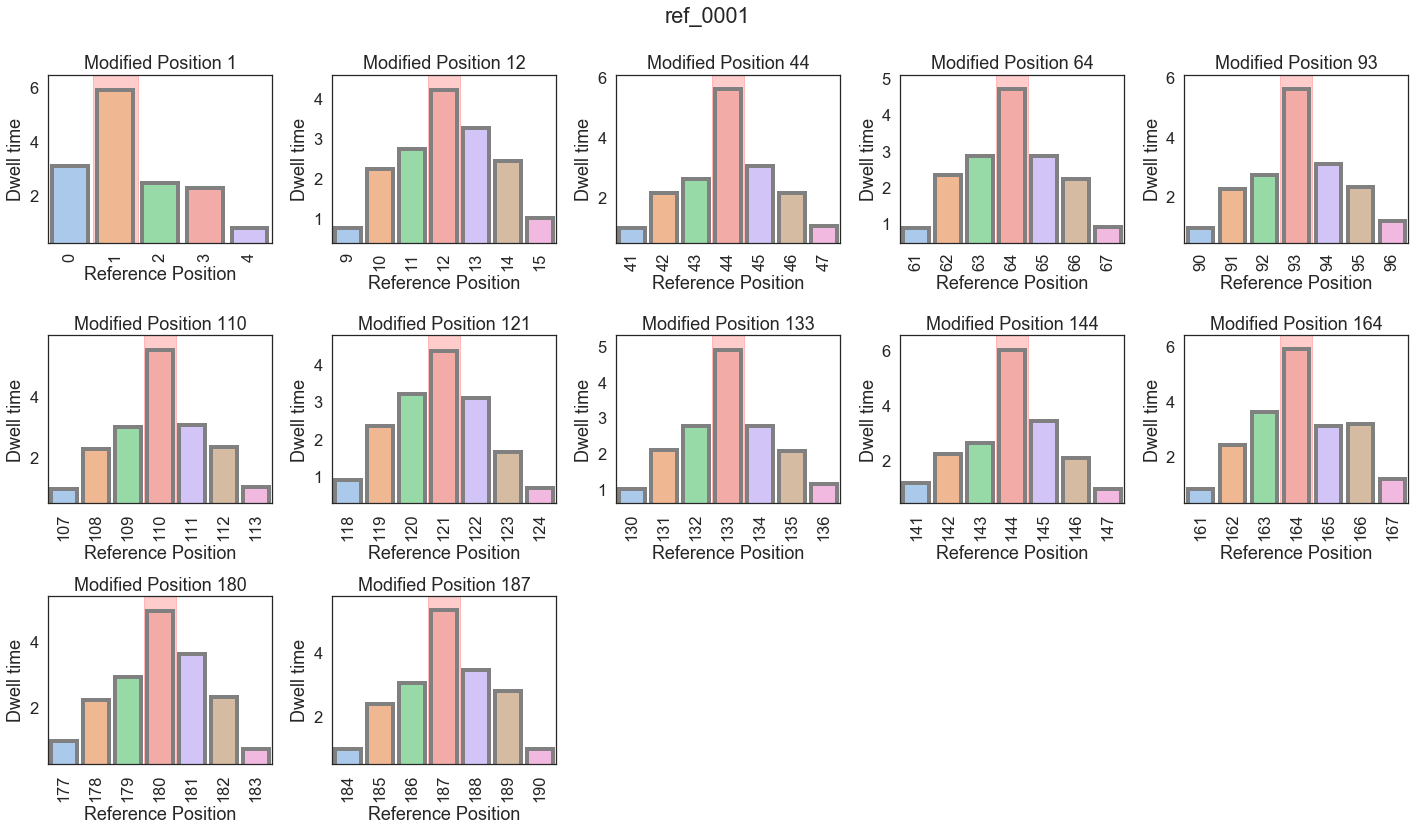

In [66]:
plot_modified_pos_ratio("ref_0001", "dwell_time")   

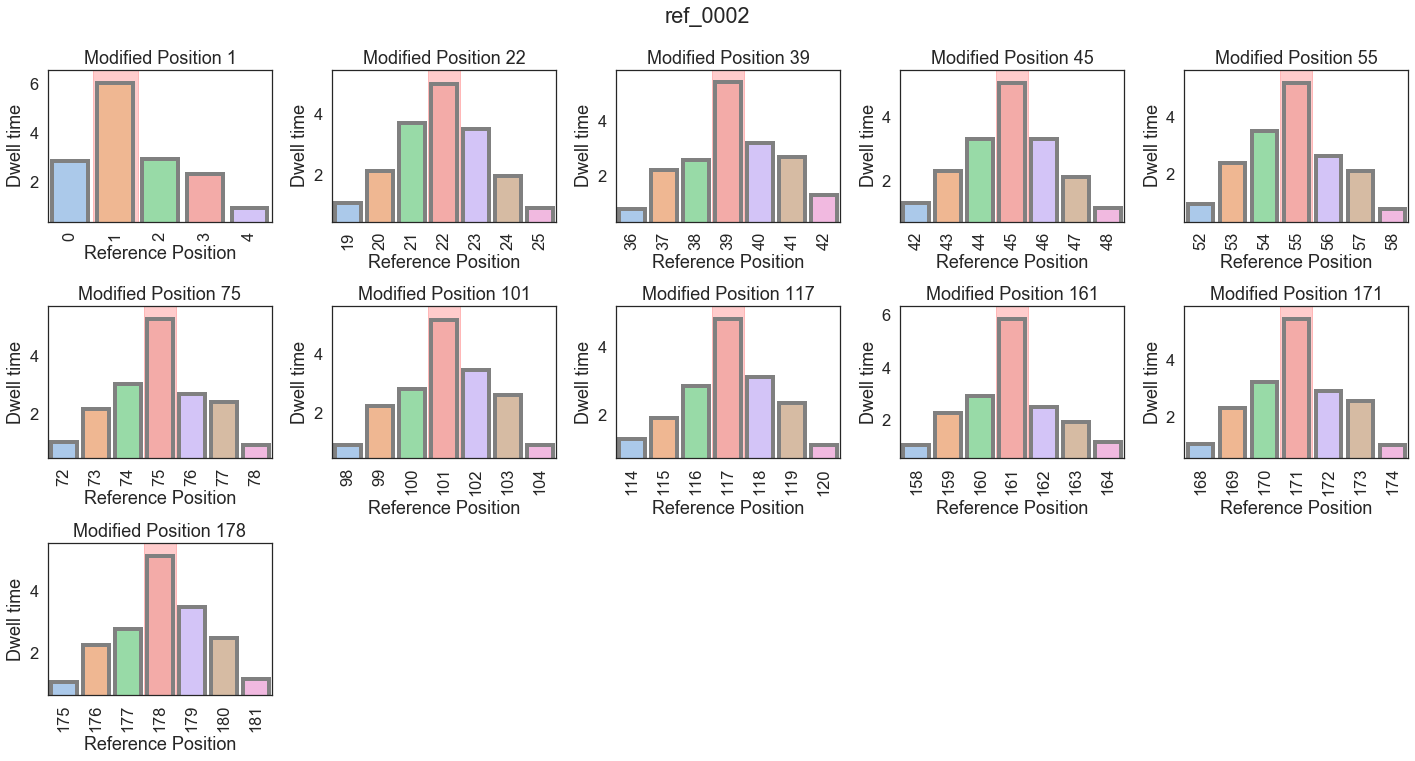

In [67]:
plot_modified_pos_ratio("ref_0002", "dwell_time")   

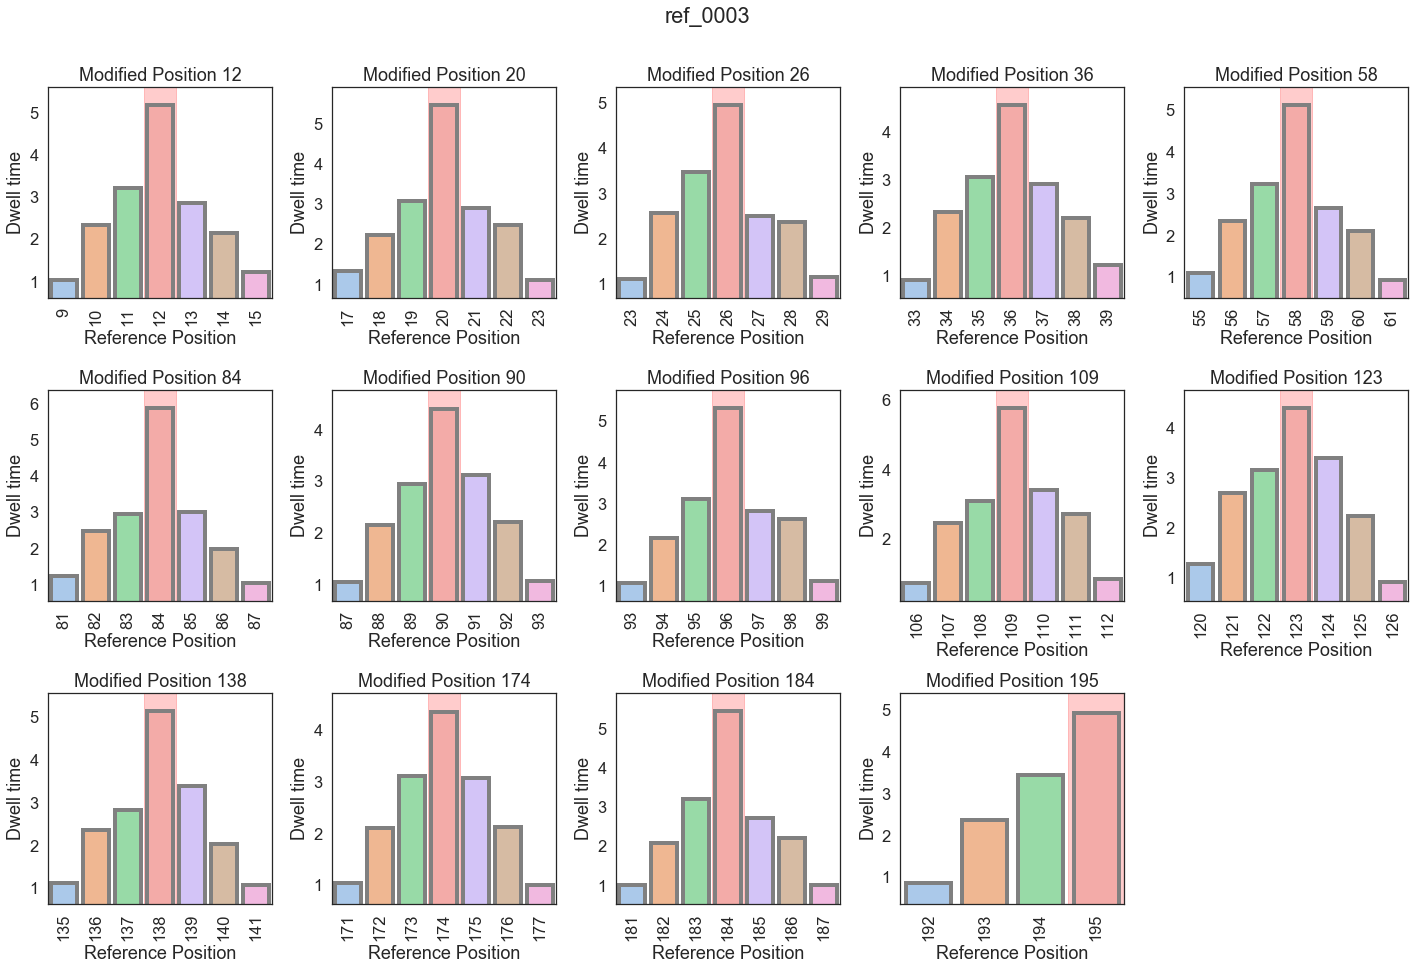

In [68]:
plot_modified_pos_ratio("ref_0003", "dwell_time")   

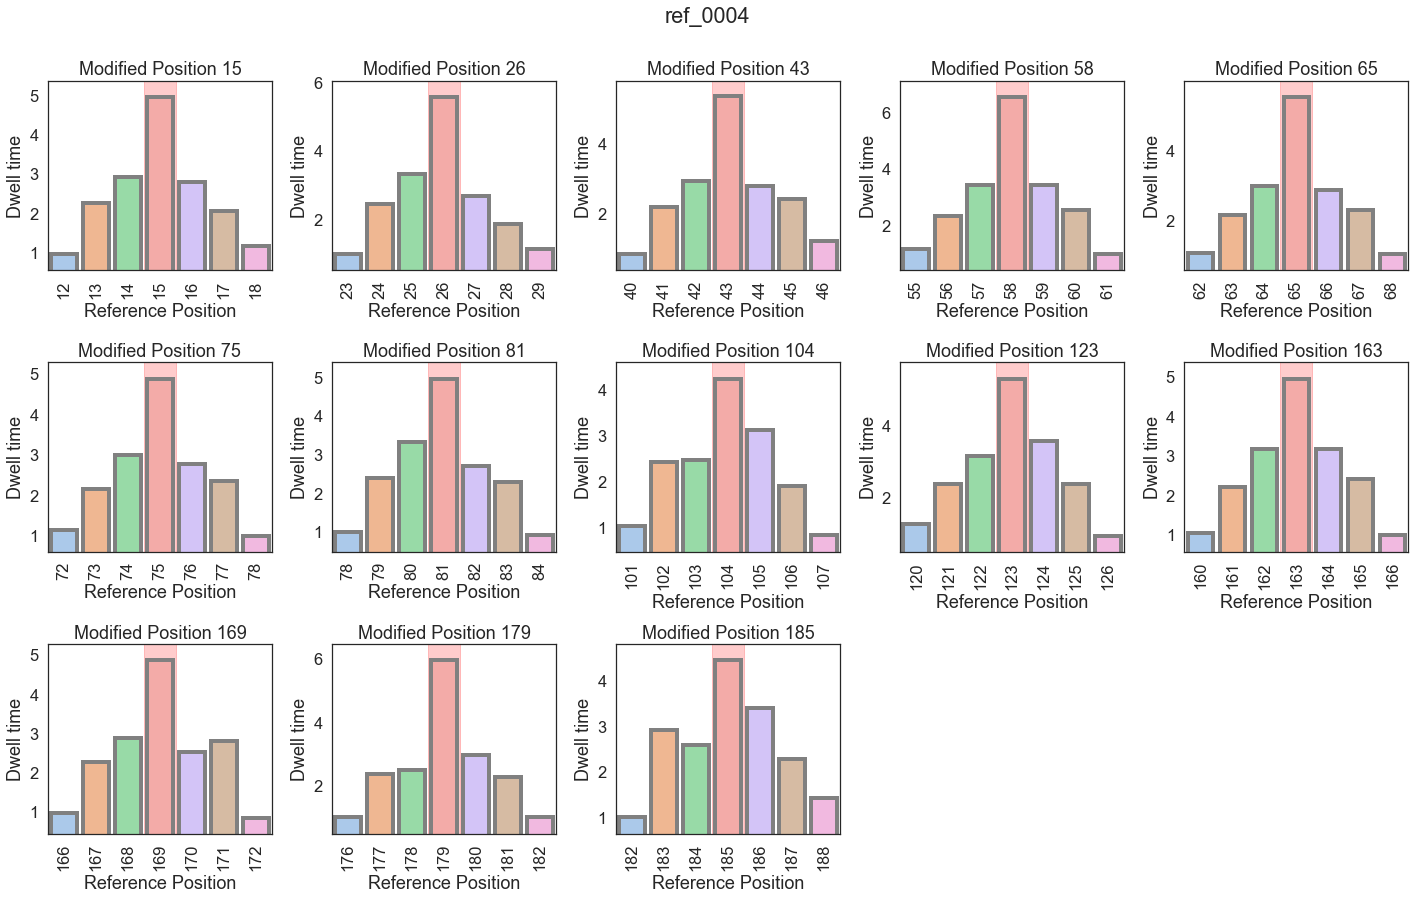

In [69]:
plot_modified_pos_ratio("ref_0004", "dwell_time")   

#### Median value

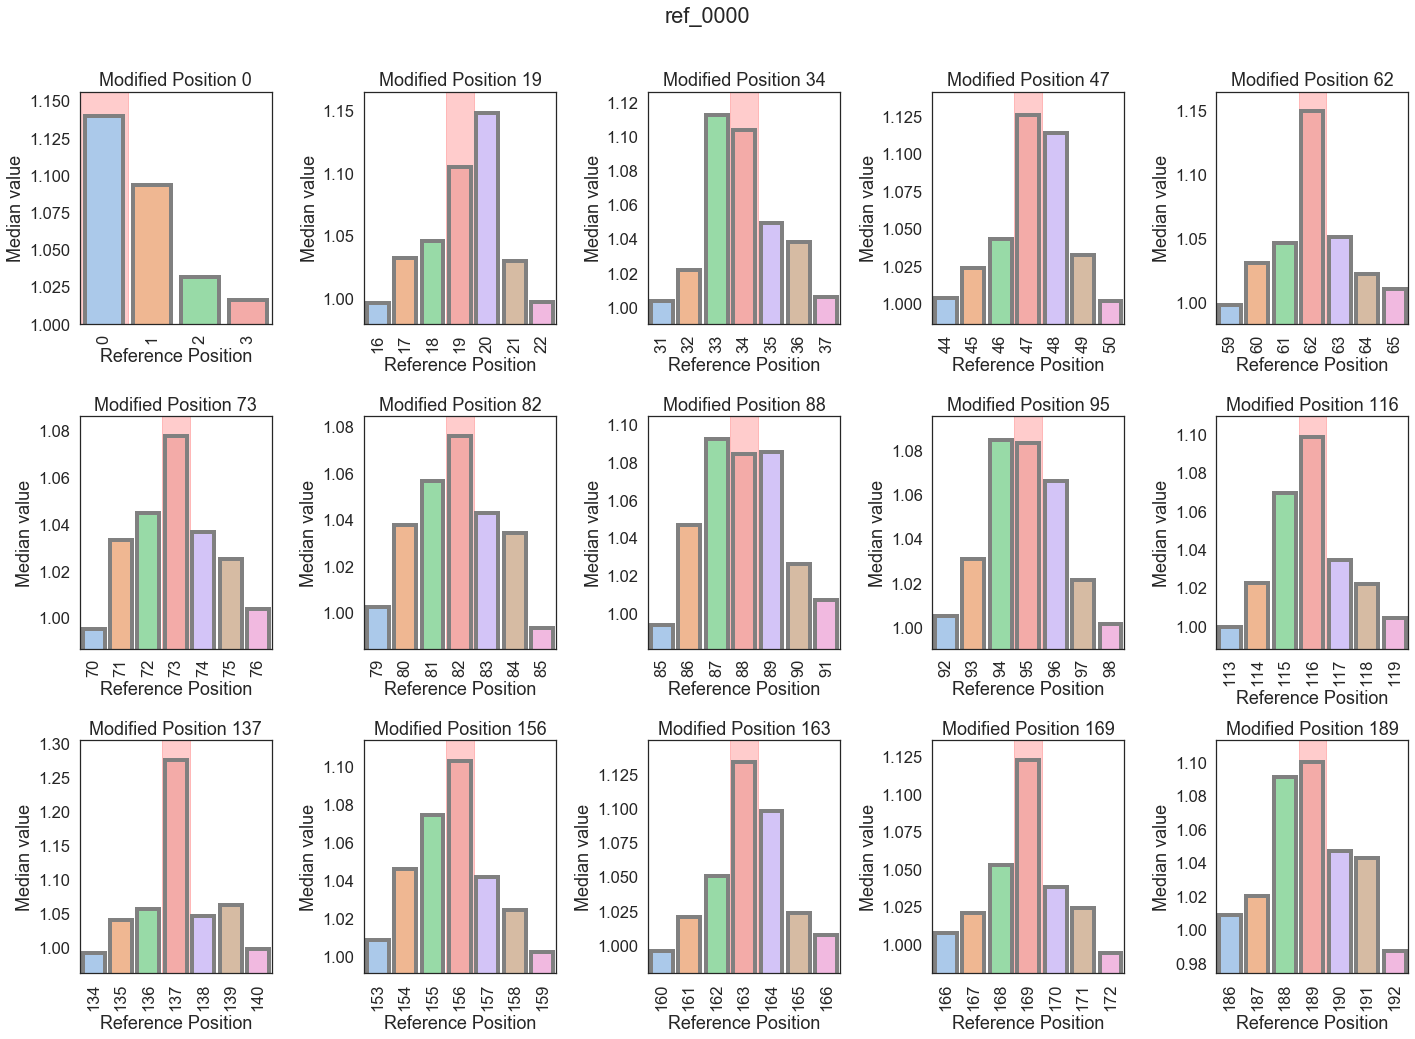

In [70]:
plot_modified_pos_ratio("ref_0000", "median_value")   

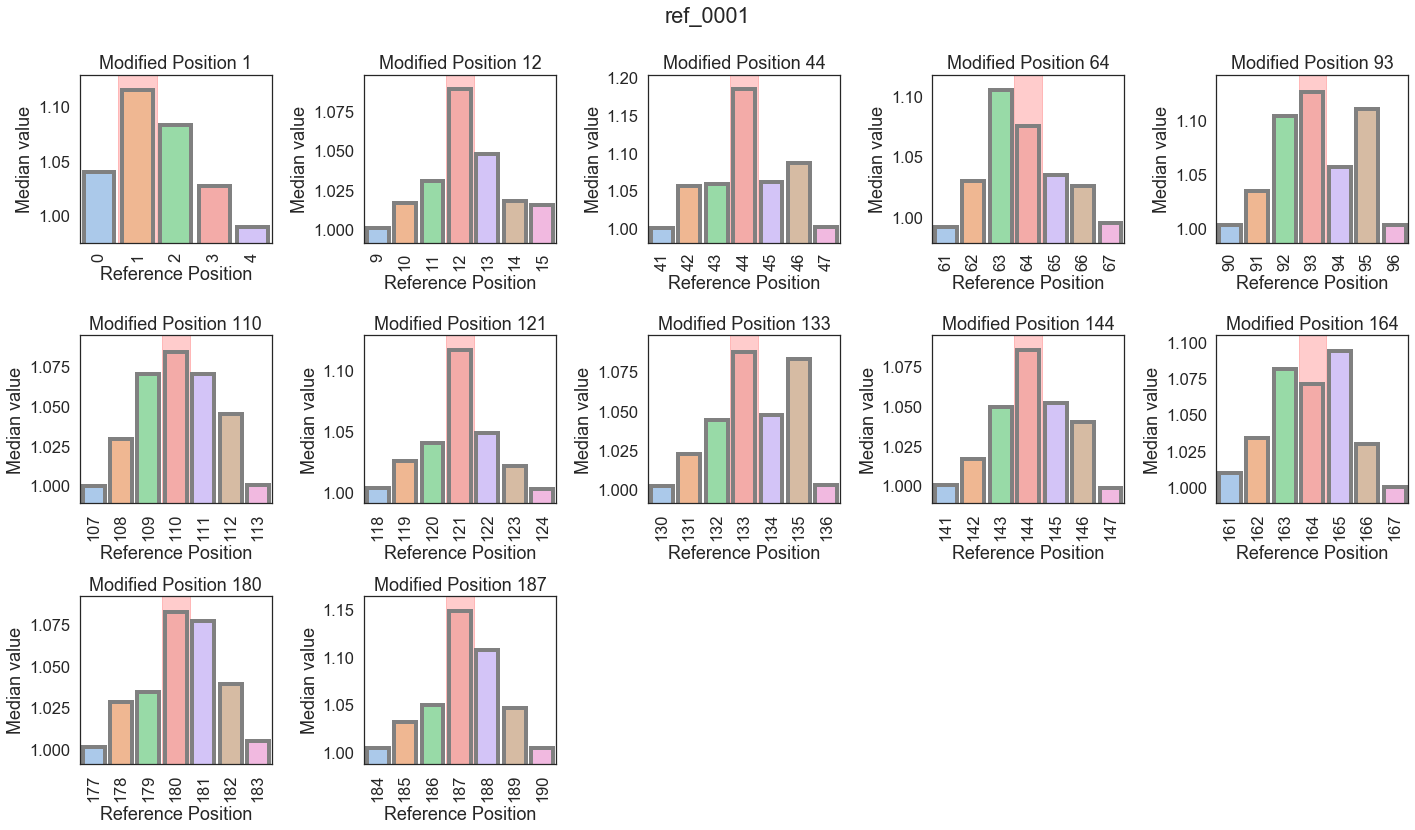

In [71]:
plot_modified_pos_ratio("ref_0001", "median_value")   

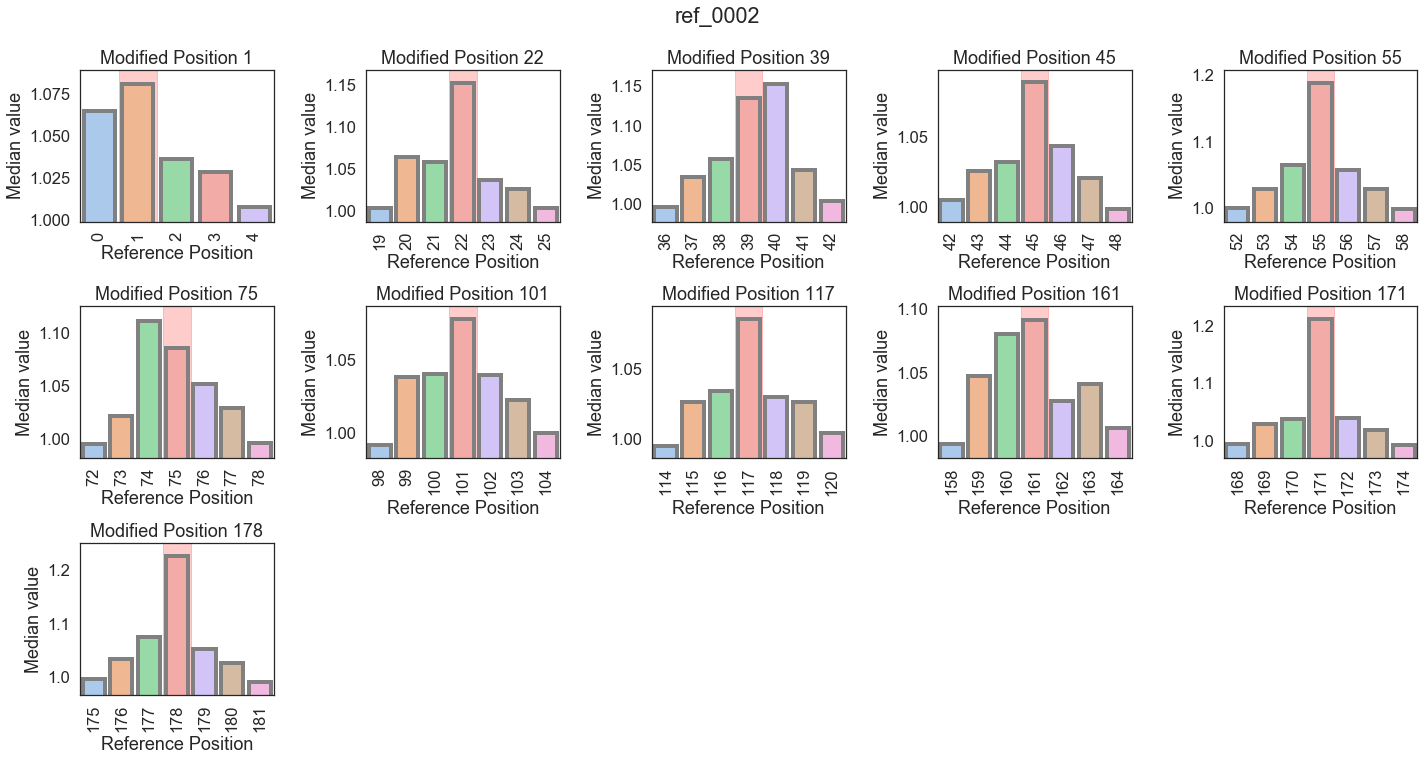

In [72]:
plot_modified_pos_ratio("ref_0002", "median_value")   

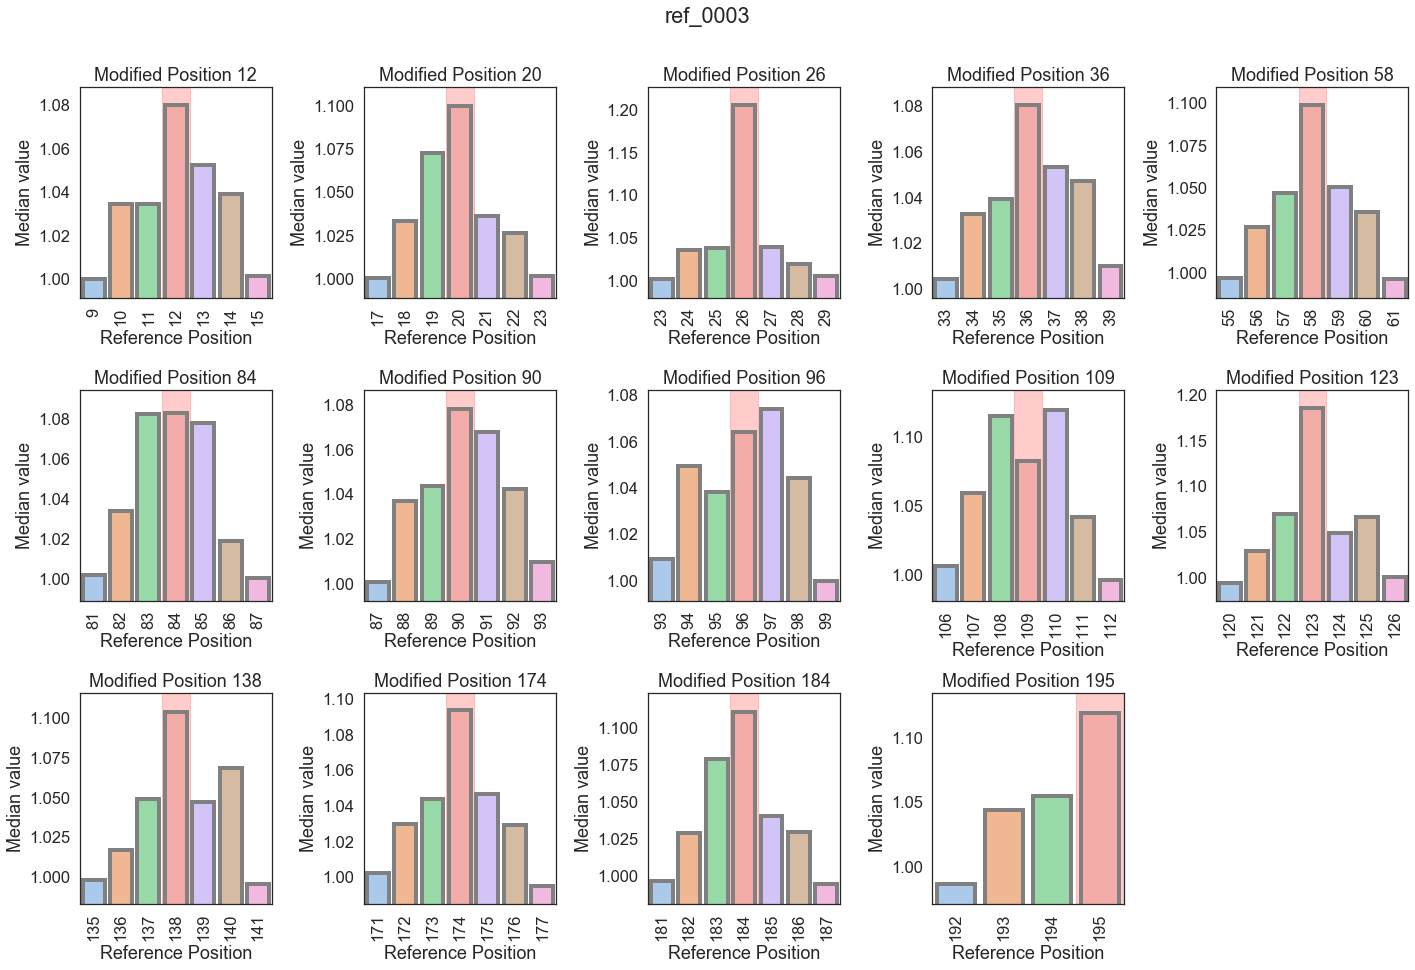

In [73]:
plot_modified_pos_ratio("ref_0003", "median_value")   

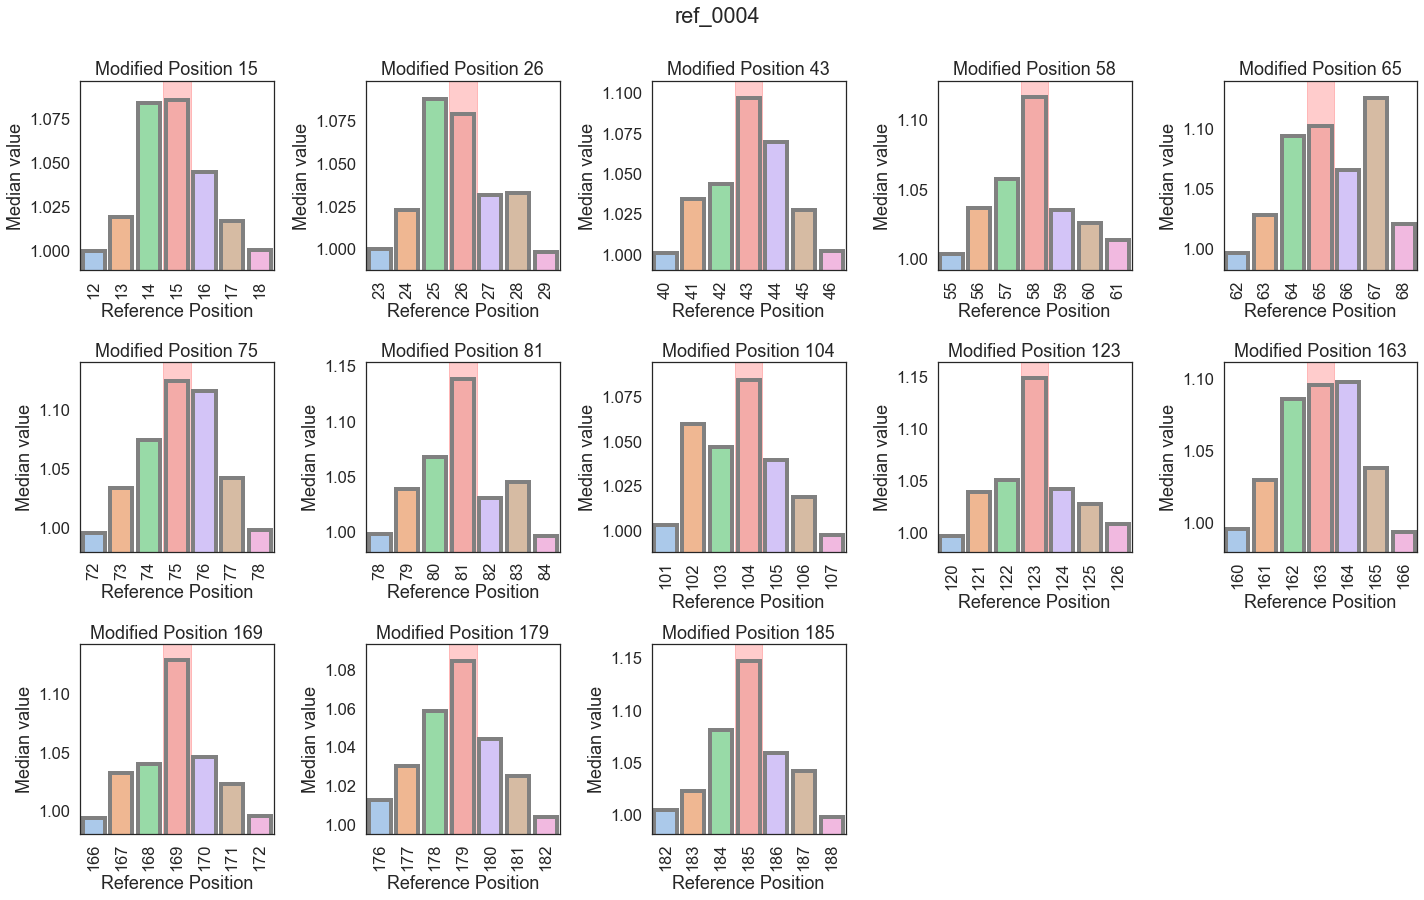

In [74]:
plot_modified_pos_ratio("ref_0004", "median_value")   

In [75]:
numeric_features_not_combined = list(df_not_combined.columns[df_not_combined.dtypes ==  "float"])

In [76]:
# interactive plot for numeric features to see if base identity is correlated to values

@interact(base = ["base_1","base_2","base_3","base_4","base_5"], 
          y_axis = list(df_not_combined.columns[df_not_combined.dtypes ==  "float"]))
def test_plot(base, y_axis):
    sns.boxplot(data = df_not_combined, y = y_axis,x="modified_status", hue=base, hue_order=["A","G","C","T"])
    plt.legend(loc="upper left");

interactive(children=(Dropdown(description='base', options=('base_1', 'base_2', 'base_3', 'base_4', 'base_5'),…

all modified positions seem to begin with an A as base_1

median values are higher if base 2 or 3 are A or G, possibly because they are purines and thus bigger molecules and maybe cause
different values in the beginning of the pore

# yeast data import

## import

In [84]:
# create list of all files in data
path = r'C:\Users\neomo\Documents\GitHub\ky-nf-capstone\data\yeast'
all_files_yeast = glob.glob(path + "\*.tsv")

In [85]:
# read in main files one by one, append file name, ref and modified state

dfy_proto = []

for file in all_files_yeast:
    file_name = os.path.basename(file)
    # split filenames into sets to compare to modified filename for later reference
    exp_set = set(os.path.basename(file).replace(".","_").split("_"))
    # have to do it complicated like this because they are underneath each other with their ref number es inbetween header
    with open(file, 'r') as csvfile:
        data = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for i in data:
            # get ref number, refnumber has only 2 entries side by side
            if len(i) == 2:
                read = i[0]
                ref = i[1]
            # for further stuff only get those where first one is integer (those are the data rows)
            try:
                int(i[0])
            except:
                pass
            else:
                # append ref and file name for later aggregation
                a = i
                a.append(ref)
                a.append(file_name)
                a.append(read)
          
                dfy_proto.append(a)
               
        
            
     

In [86]:
# form list of lists into dataframes, fill nas with 0, as they are from unmodified dataset
df_yeast_not_combined = pd.DataFrame(dfy_proto)
df_yeast_not_combined.fillna(0,inplace=True)

In [87]:
columns = ["ref_pos","ref_kmer","num_events","dwell_time","NNNNN_dwell_time","mismatch_dwell_time","mean","median_value",
           "num_signals","ref_number","file_name","read_num"]
df_yeast_not_combined.columns = columns

In [88]:
df_yeast_not_combined = df_yeast_not_combined[["ref_pos","ref_kmer","dwell_time","median_value","ref_number","file_name","read_num"]]

In [89]:
df_yeast_not_combined.ref_pos = df_yeast_not_combined.ref_pos.astype(object)
df_yeast_not_combined.ref_kmer = df_yeast_not_combined.ref_kmer.astype(str)
df_yeast_not_combined.dwell_time = df_yeast_not_combined.dwell_time.astype(float)
df_yeast_not_combined.median_value = df_yeast_not_combined.median_value.astype(float)
df_yeast_not_combined.ref_number = df_yeast_not_combined.ref_number.astype(str)
df_yeast_not_combined.file_name = df_yeast_not_combined.file_name.astype(str)
#dfy_not_combined.modified_status = dfy_not_combined.modified_status.astype("category")

In [90]:
df_yeast_not_combined.columns

Index(['ref_pos', 'ref_kmer', 'dwell_time', 'median_value', 'ref_number',
       'file_name', 'read_num'],
      dtype='object')

## aggregation

In [91]:
df_yeast_combined = df_yeast_not_combined.reset_index().groupby(["index"]).agg(["median","min","max"]).reset_index()

In [92]:
df_yeast_combined = df_yeast_combined.fillna(0)

In [93]:
df_yeast_combined.columns = [' '.join(col).strip() for col in df_yeast_combined.columns.values]
df_yeast_combined.columns =  [elm.replace(" ","_") for elm in df_yeast_combined.columns]

In [94]:
cols = list(df_yeast_combined.columns)

In [95]:
cols.pop(0)

'index'

In [96]:
df_yeast_combined = df_yeast_combined[cols]

In [97]:
df_yeast_combined = pd.concat([ df_yeast_not_combined[["file_name","ref_number","ref_pos","ref_kmer","read_num"]],df_yeast_combined,],axis=1)

In [98]:
df_yeast_combined.rename(columns = {"dwell_time_median":"dwell_time","median_value_median":"median_value"}, inplace=True)

## base split

In [99]:
kmer = [list(elm) for elm in df_yeast_not_combined.ref_kmer]
df_kmer = pd.DataFrame(kmer)
df_kmer.columns = ["base_1","base_2","base_3","base_4","base_5"]
df_yeast_not_combined = pd.concat([df_yeast_not_combined,df_kmer], axis=1)

In [100]:
kmer = [list(elm) for elm in df_yeast_combined.ref_kmer]
df_kmer = pd.DataFrame(kmer)
df_kmer.columns = ["base_1","base_2","base_3","base_4","base_5"]
df_yeast_combined = pd.concat([df_yeast_combined,df_kmer], axis=1)

## file type

In [101]:
m_fnames = ["WT_1_eventalign_collapsed.tsv","WT_2_eventalign_collapsed.tsv"]
file_type = df_yeast_not_combined["file_name"].isin(m_fnames)*1
file_type = ["WT" if i == 1 else "KO" for i in file_type]

df_yeast_not_combined["file_type"] = file_type

In [102]:
m_fnames = ["WT_1_eventalign_collapsed.tsv","WT_2_eventalign_collapsed.tsv"]
file_type = df_yeast_combined["file_name"].isin(m_fnames)*1
file_type = ["WT" if i == 1 else "KO" for i in file_type]

df_yeast_combined["file_type"] = file_type

## rolling neighbours

##### not combined

In [103]:
temp_df = rolling_neighbours(df_yeast_not_combined, "dwell_time", "median")
df_yeast_not_combined = df_yeast_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [104]:
temp_df = rolling_neighbours(df_yeast_not_combined, "median_value", "median")
df_yeast_not_combined = df_yeast_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [105]:
temp_df = rolling_neighbours(df_yeast_not_combined, "dwell_time", "min")
df_yeast_not_combined = df_yeast_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [106]:
temp_df = rolling_neighbours(df_yeast_not_combined, "median_value", "min")
df_yeast_not_combined = df_yeast_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

##### combined

In [107]:
df_yeast_combined.ref_pos = df_yeast_combined.ref_pos.astype(int)

In [108]:
temp_df = rolling_neighbours(df_yeast_combined, "dwell_time", "median", 1)
df_yeast_combined = df_yeast_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [109]:
temp_df = rolling_neighbours(df_yeast_combined, "median_value", "median", 1)
df_yeast_combined = df_yeast_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [110]:
temp_df = rolling_neighbours(df_yeast_combined, "dwell_time", "min", 1)
df_yeast_combined = df_yeast_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [111]:
temp_df = rolling_neighbours(df_yeast_combined, "median_value", "min", 1)
df_yeast_combined = df_yeast_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

## diff to median

In [112]:
temp_df = diff_to_median(df_yeast_not_combined,"dwell_time")
df_yeast_not_combined = df_yeast_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [113]:
temp_df = diff_to_median(df_yeast_not_combined,"median_value")
df_yeast_not_combined = df_yeast_not_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [114]:
df_yeast_not_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 572203 entries, 0 to 572202
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ref_pos                      572203 non-null  object 
 1   ref_kmer                     572203 non-null  object 
 2   dwell_time                   572203 non-null  float64
 3   median_value                 572203 non-null  float64
 4   ref_number                   572203 non-null  object 
 5   file_name                    572203 non-null  object 
 6   read_num                     572203 non-null  object 
 7   base_1                       572203 non-null  object 
 8   base_2                       572203 non-null  object 
 9   base_3                       572203 non-null  object 
 10  base_4                       572203 non-null  object 
 11  base_5                       572203 non-null  object 
 12  file_type                    572203 non-null  object 
 13 

##### combined

In [115]:
temp_df = diff_to_median(df_yeast_combined,"dwell_time")
df_yeast_combined = df_yeast_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [116]:
temp_df = diff_to_median(df_yeast_combined,"median_value")
df_yeast_combined = df_yeast_combined.merge(temp_df, how = "outer", on=["ref_number","file_name","read_num","ref_pos"])

In [117]:
df_yeast_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 572203 entries, 0 to 572202
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   file_name                    572203 non-null  object 
 1   ref_number                   572203 non-null  object 
 2   ref_pos                      572203 non-null  int32  
 3   ref_kmer                     572203 non-null  object 
 4   read_num                     572203 non-null  object 
 5   dwell_time                   572203 non-null  float64
 6   dwell_time_min               572203 non-null  float64
 7   dwell_time_max               572203 non-null  float64
 8   median_value                 572203 non-null  float64
 9   median_value_min             572203 non-null  float64
 10  median_value_max             572203 non-null  float64
 11  base_1                       572203 non-null  object 
 12  base_2                       572203 non-null  object 
 13 

## outlier removal

In [118]:
from scipy import stats
import numpy as np

In [119]:
z_data = df_yeast_combined[["dwell_time","dwell_time_rolling_min","dwell_time_diff_to_median"]]

In [121]:
z = np.abs(stats.zscore(z_data))

[[0.02690506 0.37408245 0.04758335]
 [0.08078727 0.37408245 0.06074076]
 [0.47966487 0.37408245 0.46195836]
 ...
 [0.24948984 0.53680167 0.25344608]
 [2.28289761 0.53680167 2.29379753]
 [0.34146741 1.10025228 0.34596323]]


In [127]:
threshold = 3
len(np.where(z > 3)[0])

21939

In [128]:
df_yeast_combinedo = df_yeast_combined[(z < 3).all(axis=1)]

In [129]:
df_yeast_combined.shape

(572203, 23)

In [130]:
df_yeast_combinedo.shape

(556983, 23)

# export data

In [133]:
# export data frames to new csvs for use in modelling

df_combined.to_csv("data/exported/df_combined.csv")
df_not_combined.to_csv("data/exported/df_not_combined.csv")
df_yeast_not_combined.to_csv("data/exported/df_yeast_not_combined.csv")
df_yeast_combined.to_csv("data/exported/df_yeast_combined.csv")
df_yeast_combinedo.to_csv("data/exported/df_yeast_combinedo.csv")